 # Task 1: Dataset description (5%)

 ## 1.1 Setup

In [1]:

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, OrdinalEncoder, MinMaxScaler
import random
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from skimpy import skim, generate_test_data
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, make_scorer, fbeta_score, accuracy_score, roc_auc_score, precision_score, recall_score
from matplotlib.lines import Line2D
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance

In [2]:
# Set random seed for replicability

SEED = 21
random.seed(SEED)
np.random.seed(SEED)


 ## 1.2 Initial data exploration

In [3]:
# Display initial rows of IDs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)
IDS_df = pd.read_csv('./data/IDS_mapping.csv')
IDS_df.head()


,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [4]:
# Display database and print columns
diabetic_df = pd.read_csv('./data/diabetic_data.csv')



print(diabetic_df.columns)

diabetic_df.head()


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
# Look at shape of database

diabetic_df.shape


(101766, 50)

In [6]:
# Simplify for task - combine classifications in target column

diabetic_df["readmitted"] = diabetic_df["readmitted"].apply(lambda x: "YES" if x in [">30", "<30"] else x)



 ### Check for missing values

In [7]:
# Replace specific missing values (e.g. ?, Unknown, etc.) with np.nan
diabetic_df.loc[diabetic_df['discharge_disposition_id'] == 18, 'discharge_disposition_id'] = np.nan
diabetic_df.loc[diabetic_df['admission_source_id'] == 17, 'admission_source_id'] = np.nan
diabetic_df.loc[diabetic_df['gender'] == "Unknown/Invalid", 'gender'] = np.nan
diabetic_df = diabetic_df.replace('?', np.nan)

# Calculate total missing values
total_missing = diabetic_df.isnull().sum()

# Calculate percentage and round to one decimal place
percentage_missing = (total_missing / len(diabetic_df) * 100).round(1)

# Create DataFrame
missing_df = pd.DataFrame({
    'Missing values': total_missing,
    'Percentage of total': percentage_missing
})

pd.set_option('display.max_rows', 50)

missing_df


,Missing values,Percentage of total
encounter_id,0,0.0
patient_nbr,0,0.0
race,2273,2.2
gender,3,0.0
age,0,0.0
weight,98569,96.9
admission_type_id,0,0.0
discharge_disposition_id,3691,3.6
admission_source_id,6781,6.7
time_in_hospital,0,0.0


In [8]:
# Export missing values to csv file for report
missing_df.to_csv('missing_df.csv', index=True)


In [9]:
# Identify data types 
discrete_cols = ['number_diagnoses', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',]

drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

cat_cols_subset = ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code','max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'readmitted'] # Categorical excluding drug cols and patient number

high_cardinality_cols = ['medical_specialty', 'diag_1', 'diag_2', 'diag_3']

# We excluded encounter_id
cat_cols = ['patient_nbr'] + cat_cols_subset + high_cardinality_cols + drug_cols



 ## 1.3 Data visualization

 ### 1.3.1. Discrete columns

 #### Distributions

In [10]:
# Provide overview of statistics
skim(diabetic_df[discrete_cols])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 101766 │ │ int64       │ 8     │                                                          │
│ │ Number of columns │ 8      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA   ┃ NA %   ┃ mean   ┃ sd     ┃ p0  ┃ p25   ┃ p50   ┃ p75  ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ number_diagnoses          │    0 │      0 │    7.4 │    1.9 │   1 │     6 │     8 │    9 │    16 │  ▁▃▅▇   │  │
│ │ time_in_hospital          │    0 │      0 │    4.4 │      3 │   1 │     2 │     4 │    6 │    14 │ ▇▃▂▁▁▁  │  │
│ │ num_lab_procedures        │    0 │      0 │     43 │     20 │   1 │    31 │    44 │   57 │   130 │  ▃▇▇▂   │  │
│ │ num_procedures            │    0 │      0 │    1.3 │    1.7 │   0 │     0 │     1 │    2 │     6 │ ▇▃▂▂▁▁  │  │
│ │ num_medications           │    0 │      0 │     16 │    8.1 │   1 │    10 │    15 │   20 │    81 │   ▇▇▁   │  │
│ │ number_outpatient         │    0 │      0 │   0.37 │    1.3 │   0 │     0 │     0 │    0 │    42 │    ▇    │  │
│ │ number_emergency          │    0 │      0 │    0.2 │   0.93 │   0 │     0 │     0 │    0 │    76 │    ▇    │  │
│ │ number_inpatient          │    0 │      0 │   0.64 │    1.3 │   0 │     0 │     0 │    1 │    21 │    ▇    │  │
│ └───────────────────────────┴──────┴────────┴────────┴────────┴─────┴───────┴───────┴──────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

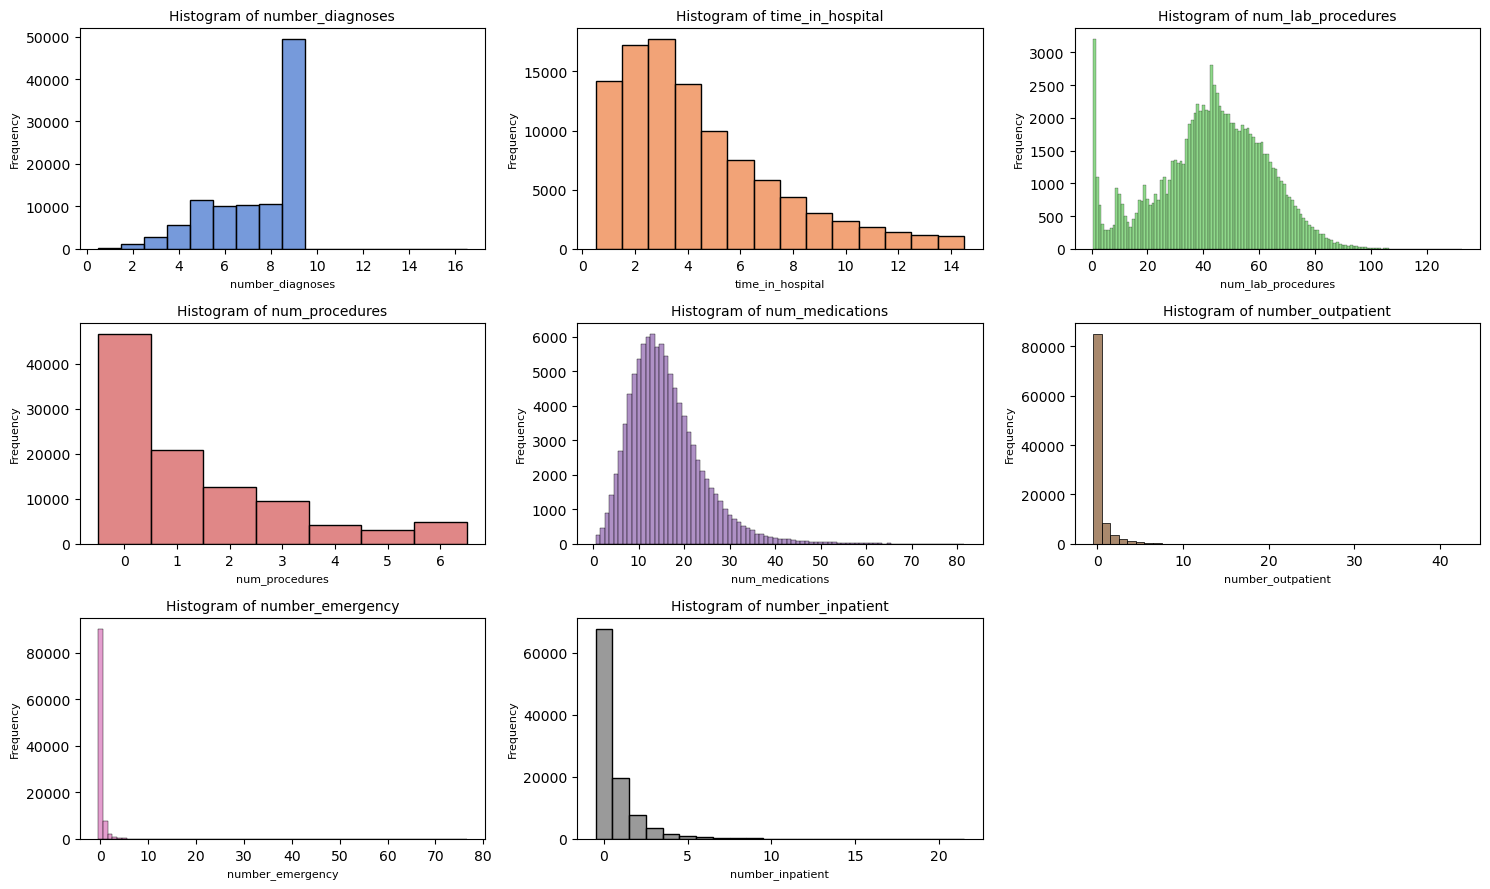

In [11]:
# Plot histograms for each discrete column

# Set up subplot
n = len(discrete_cols)
palette = sns.color_palette("muted", n) #Cycle through colours
n_cols = 3
n_rows = n // n_cols if n % n_cols == 0 else n // n_cols + 1
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 3*n_rows))
axs = axs.ravel() # Reshape axs to 1-D array for for loop

for i, col in enumerate(discrete_cols):
    # Plot the data in histograms
    sns.histplot(diabetic_df[col], bins=30, ax=axs[i], color=palette[i], discrete=True)

    #Formatting and labelling
    axs[i].set_title(f"Histogram of {col}", fontsize=10)
    axs[i].set_xlabel(xlabel=col, fontsize=8)
    axs[i].set_ylabel(ylabel="Frequency", fontsize=8)

# Remove unused subplots
for i in range(n, n_rows*n_cols):
    fig.delaxes(axs[i])

# Show charts
plt.tight_layout()
plt.show()


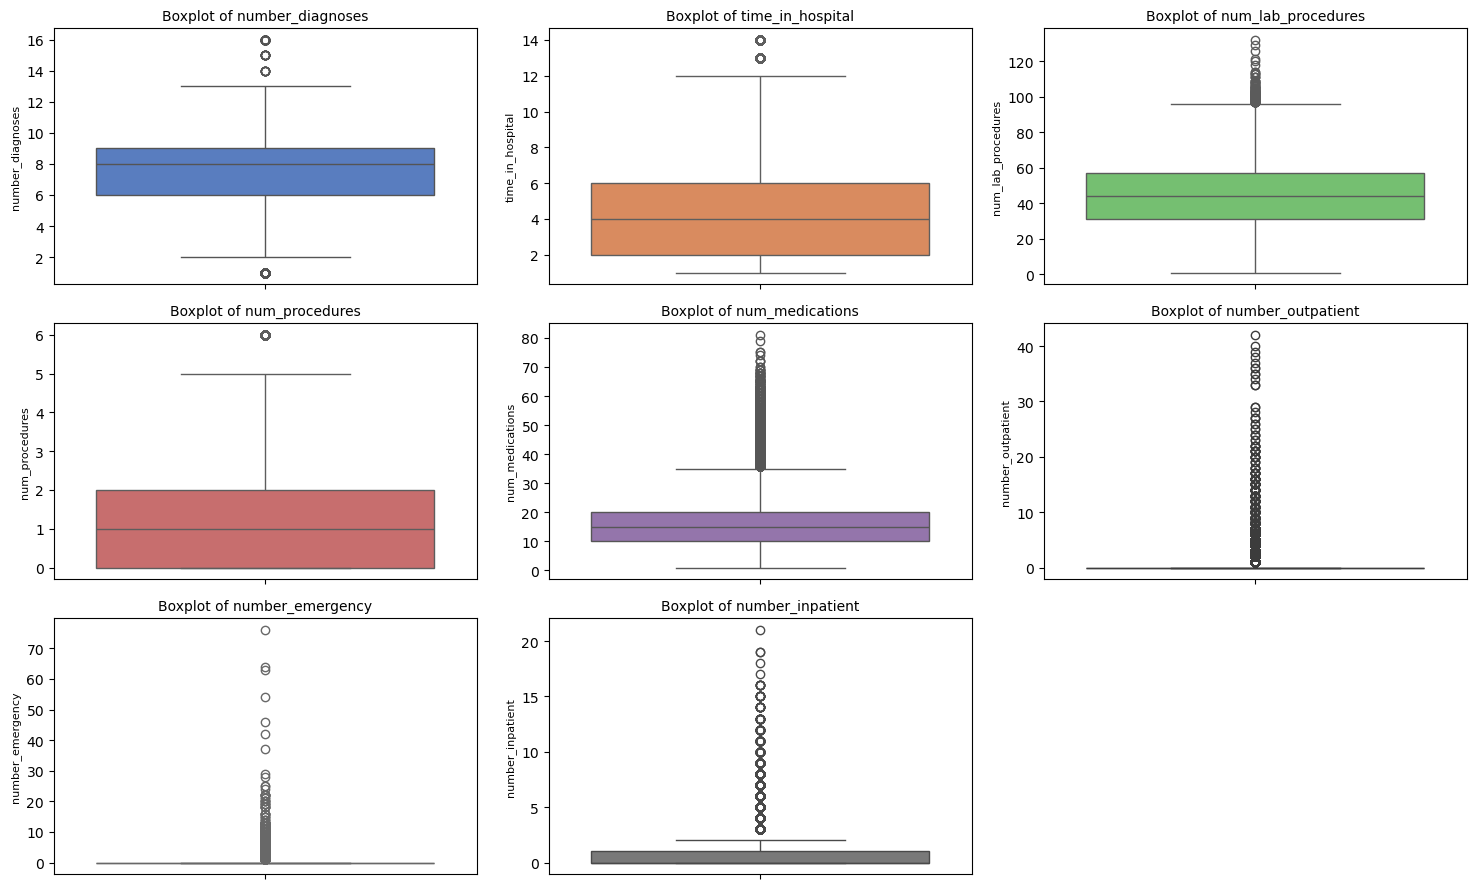

In [12]:
# Plot boxplots for each discrete column

# Set up subplot
n = len(discrete_cols)
palette = sns.color_palette("muted", n) #Cycle through colours
n_cols = 3
n_rows = n // n_cols if n % n_cols == 0 else n // n_cols + 1
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 3*n_rows))
axs = axs.ravel() # Reshape axs to 1-D array for for loop

for i, col in enumerate(discrete_cols):
    # Plot the data in boxplots
    sns.boxplot(y=diabetic_df[col], ax=axs[i], color=palette[i])
    
    #Formatting and labelling
    axs[i].set_title(f"Boxplot of {col}", fontsize=10)
    axs[i].set_ylabel(ylabel=col, fontsize=8)

# Remove unused subplots
for i in range(n, n_rows*n_cols):
    fig.delaxes(axs[i])

# Show charts
plt.tight_layout()
plt.show()


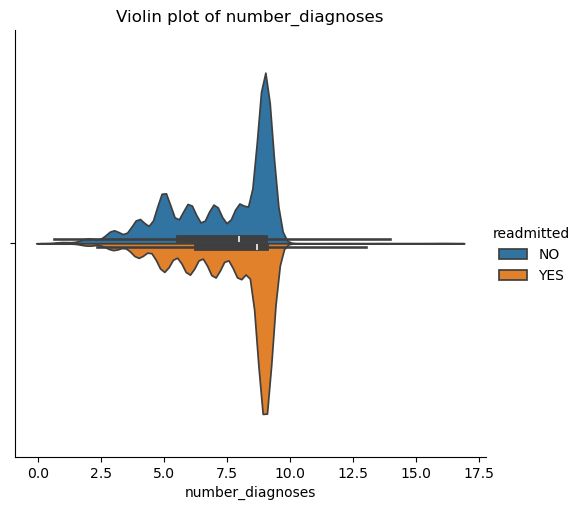

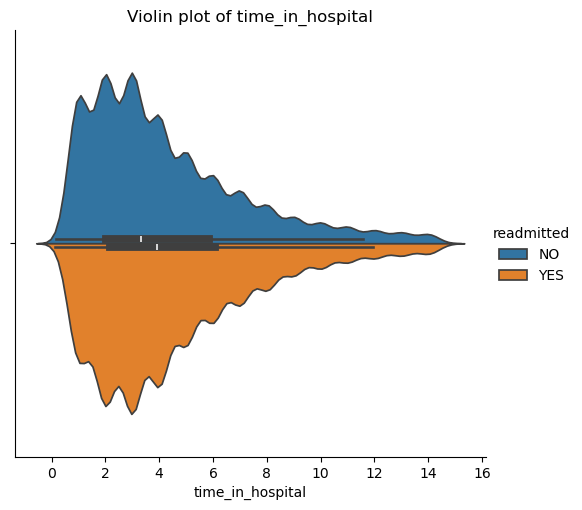

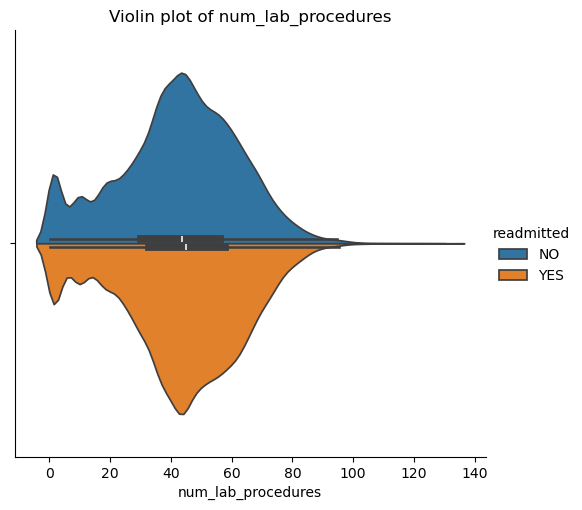

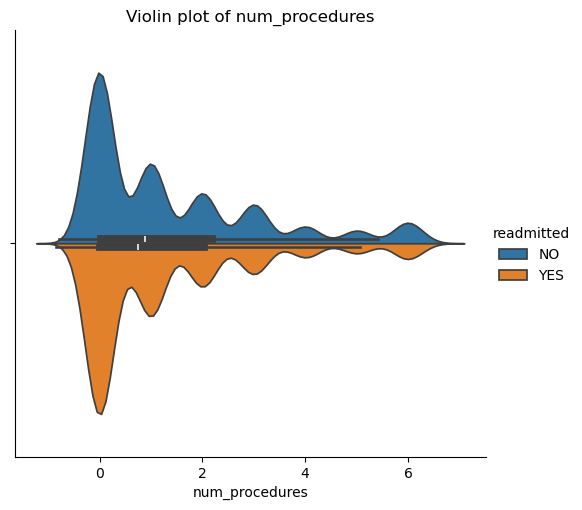

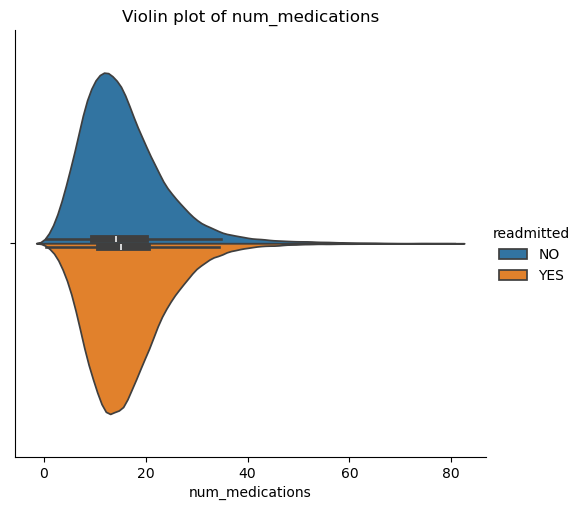

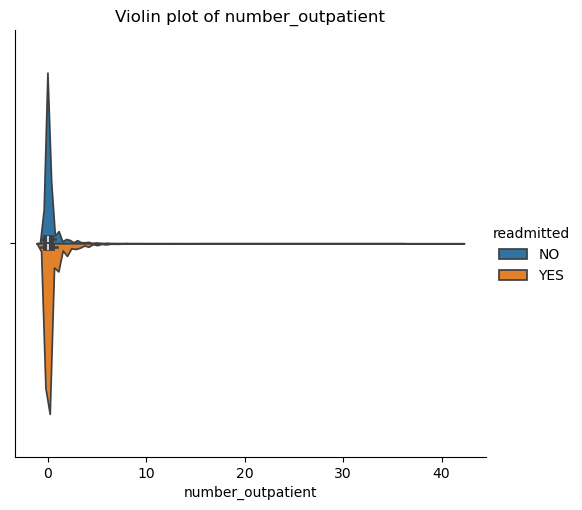

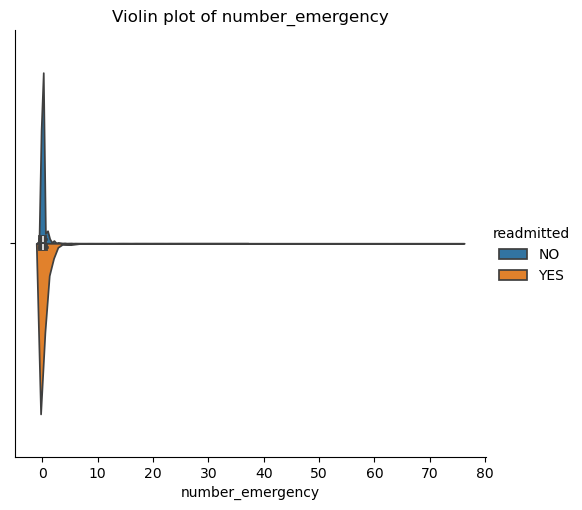

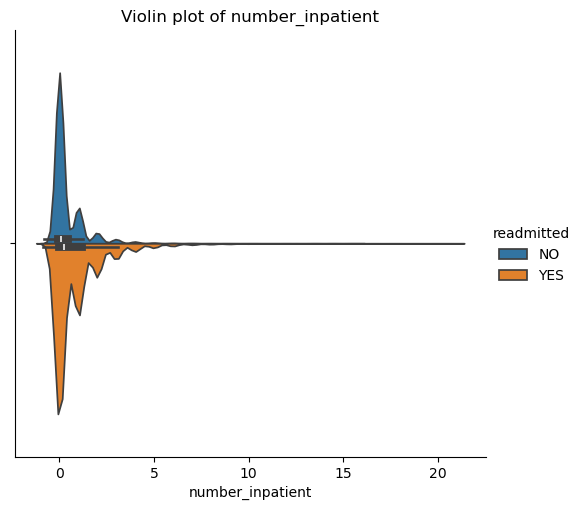

In [13]:
# Violin plots to understand the distribution of each discrete column with respect to the readmitted/not readmitted target.  
# Not included in report but was good to confirm overall distribution is similar in each one

# Loop through discrete columns
for col in discrete_cols:
    
    # Add small amount of random noise to data
    jittered_data = diabetic_df[col] + np.random.normal(0, 0.2, size=len(diabetic_df)) # Added noise as discrete
    
    # Create catplot
    sns.catplot(x=jittered_data, kind='violin', hue='readmitted', split=True, data=diabetic_df)
    
    # Formatting and labelling
    plt.title(f"Violin plot of {col}")
    
    # Show charts
    plt.show()


 #### Correlations

<Axes: >

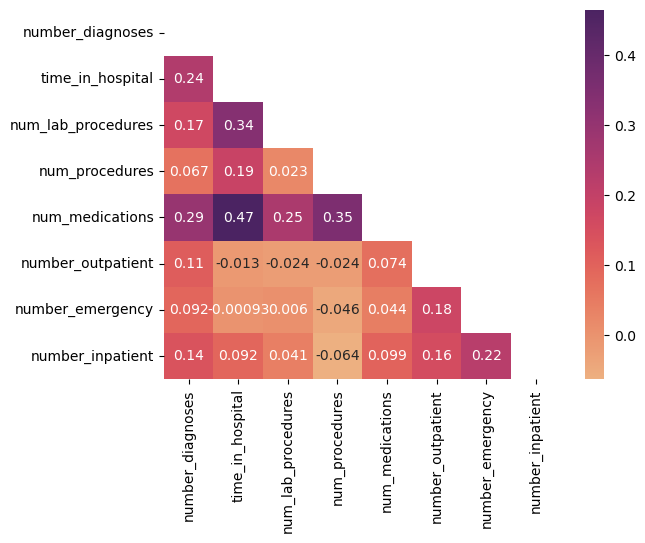

In [14]:
# Plot Spearman's correlation between discrete values

corr_matrix = diabetic_df[discrete_cols].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap=sns.color_palette("flare", as_cmap=True))


 ### 1.3.2 Categorical columns

 #### Overall distributions

In [15]:
# Plot overall statistics of categorical columns

skim(diabetic_df[cat_cols])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 101766 │ │ string      │ 37    │                                                          │
│ │ Number of columns │ 41     │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_nam ┃      ┃      ┃          ┃          ┃     ┃          ┃          ┃          ┃           ┃        ┃  │
│ ┃ e          ┃ NA   ┃ NA % ┃ mean     ┃ sd       ┃ p0  ┃ p25      ┃ p50      ┃ p75      ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ patient_nb │    0 │    0 │ 54000000 │ 39000000 │ 140 │ 23000000 │ 46000000 │ 88000000 │ 190000000 │  ▇▅▅▃  │  │
│ │ r          │      │      │          │          │     │          │          │          │           │        │  │
│ │ admission_ │    0 │    0 │        2 │      1.4 │   1 │        1 │        1 │        3 │         8 │ ▇▂ ▁▁  │  │
│ │ type_id    │      │      │          │          │     │          │          │          │           │        │  │
│ │ discharge_ │ 3691 │ 3.63 │      3.2 │      4.6 │   1 │        1 │        1 │        3 │        28 │   ▇▁   │  │
│ │ dispositio │      │      │          │          │     │          │          │          │           │        │  │
│ │ n_id       │      │      │          │          │     │          │          │          │           │        │  │
│ │ admission_ │ 6781 │ 6.66 │        5 │      2.8 │   1 │        1 │        7 │        7 │        25 │   ▅▇   │  │
│ │ source_id  │      │      │          │          │     │          │          │          │           │        │  │
│ └────────────┴──────┴──────┴──────────┴──────────┴─────┴──────────┴──────────┴──────────┴───────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA         ┃ NA %       ┃ words per row          ┃ total words        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ race                               │       2273 │       2.23 │                   0.98 │              99493 │  │
│ │ gender                             │          3 │          0 │                      1 │             101763 │  │
│ │ age                                │          0 │          0 │                      1 │             101766 │  │
│ │ weight                             │      98569 │      96.86 │                  0.031 │               3197 │  │
│ │ payer_code                         │      40256 │      39.56 │                    0.6 │              61510 │  │
│ │ max_glu_serum                      │      96420 │      94.75 │                  0.053 │               5346 │  │
│ │ A1Cresult                          │      84748 │   

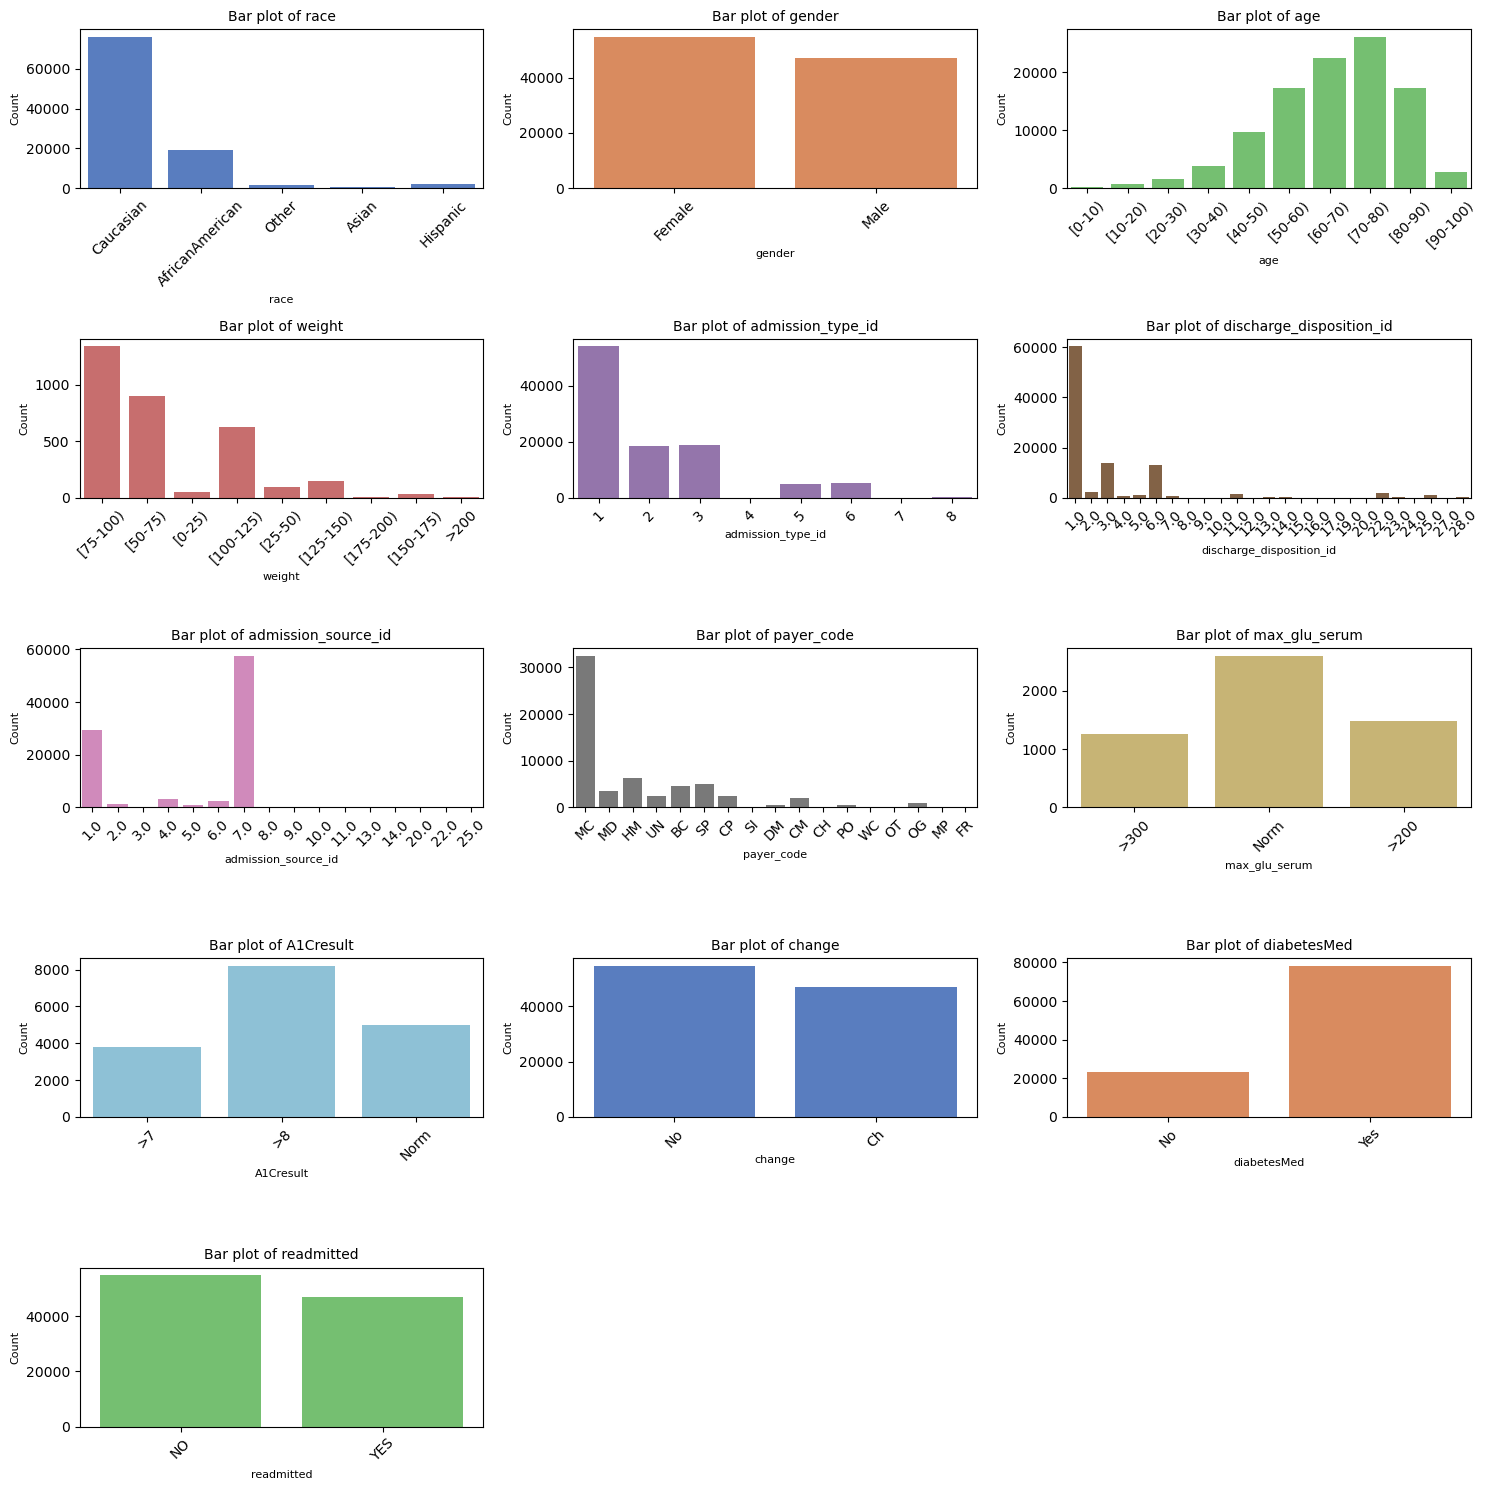

In [16]:
# Plot bar plots of each categorical column
# Set up subplot
n = len(cat_cols_subset)  # use your categorical columns
palette = sns.color_palette("muted", n)  # Cycle through colours
n_cols = 3
n_rows = n // n_cols if n % n_cols == 0 else n // n_cols + 1
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 3*n_rows))
axs = axs.ravel()  # Reshape axs to 1-D array for for loop

for i, col in enumerate(cat_cols_subset):  # use your categorical columns
    # Plot the data in bar plots
    sns.countplot(x=col, data=diabetic_df, ax=axs[i], color=palette[i])
    
    # Formatting and labelling
    axs[i].set_title(f"Bar plot of {col}", fontsize=10)
    axs[i].set_xlabel(xlabel=col, fontsize=8)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_ylabel(ylabel="Count", fontsize=8)

# Remove unused subplots
for i in range(n, n_rows*n_cols):
    fig.delaxes(axs[i])

# Show charts
plt.tight_layout()
plt.show()


 #### High-cardinality visualisations

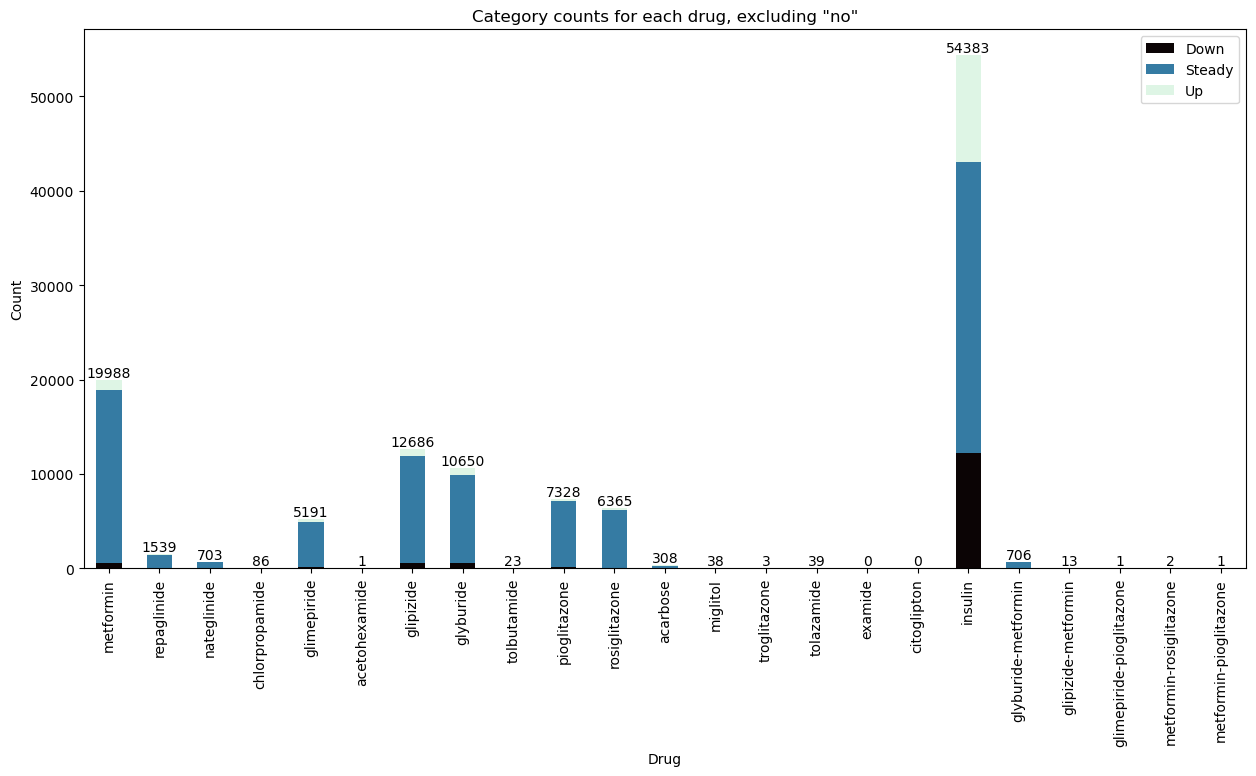

In [17]:
# Stacked bar plot for drugs, excluding "no" category

# Create a DataFrame of category counts for each drug, excluding "no" category
count_df = diabetic_df[drug_cols].apply(lambda x: x.value_counts()).transpose()
count_df = count_df.drop('No', axis=1)

# Create a stacked bar plot
ax = count_df.plot(kind='bar', stacked=True, colormap='mako', figsize=(15, 7))

# Add total count above each bar
for i in range(len(count_df)):
    total = count_df.iloc[i].sum()
    ax.text(i, total, '{:.0f}'.format(total), ha='center', va='bottom')

plt.title('Category counts for each drug, excluding "no"')
plt.xlabel('Drug')
plt.ylabel('Count')
plt.show()


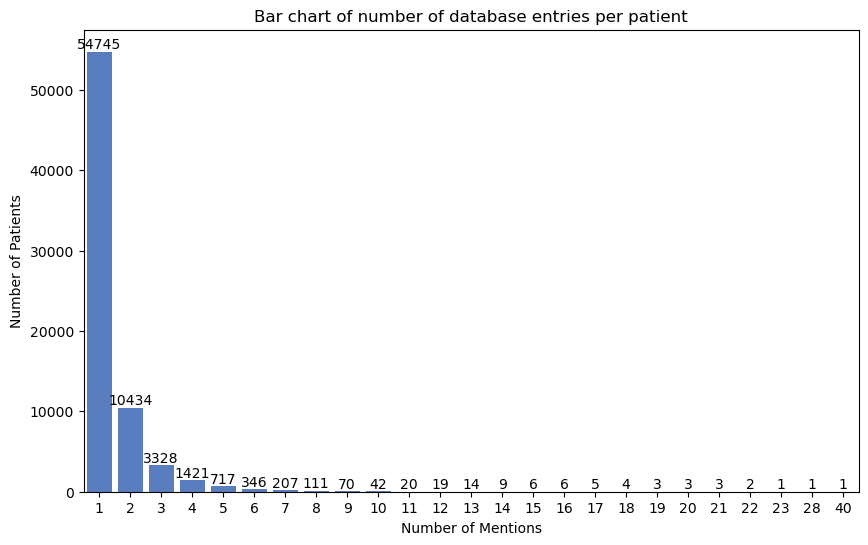

In [18]:
# Get the counts of each patient number
counts = diabetic_df['patient_nbr'].value_counts()

# Count the frequencies of each count
frequency_counts = counts.value_counts()

# Convert the frequency counts to a DataFrame for plotting
df = pd.DataFrame({'Number of Mentions': frequency_counts.index, 'Number of Patients': frequency_counts.values})

palette = sns.color_palette("muted")

# Create the bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Number of Mentions', y='Number of Patients', data=df, color=palette[0])

# Add labels to the bars
for i in range(df.shape[0]):
    barplot.text(i, df['Number of Patients'].iloc[i], df['Number of Patients'].iloc[i], ha='center', va='bottom')

plt.title('Bar chart of number of database entries per patient')
plt.show()


In [19]:
# Count the occurrences of each patient ID
id_counts = diabetic_df['patient_nbr'].value_counts()

# Count the number of patient IDs that appear more than once
duplicate_id_count = sum(id_counts > 1)

print("Number of patients with multiple database entries:", duplicate_id_count)


Number of patients with multiple database entries: 16773


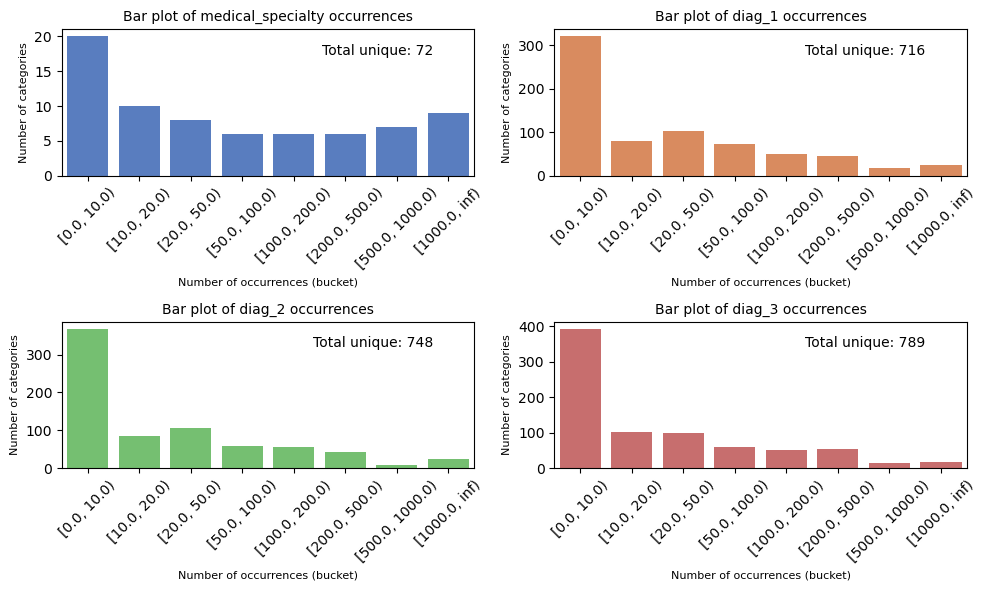

In [20]:
# This code visualizes the distribution of categorical variables with high cardinality in a dataset.
# For each variable, it calculates the frequency of each category, bucketizes these frequencies, and plots them in a bar plot.

# Define the bucket ranges
bins = [0, 10, 20, 50, 100, 200, 500, 1000, np.inf]

# Set up subplot
n = len(high_cardinality_cols)  # use your categorical columns
palette = sns.color_palette("muted", n)  # Cycle through colours
n_cols = 2
n_rows = n // n_cols if n % n_cols == 0 else n // n_cols + 1
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 3*n_rows))
axs = axs.ravel()  # Reshape axs to 1-D array for for loop

for i, col in enumerate(high_cardinality_cols):  # use your categorical columns
    # Calculate the frequency of each ID
    id_counts = diabetic_df[col].value_counts()

    # Bucketize the counts
    bucketized_counts = pd.cut(id_counts, bins=bins, include_lowest=True, right=False).value_counts()
    bucketized_counts = bucketized_counts.sort_index()

    # Plot the data in bar plots
    sns.barplot(x=bucketized_counts.index.astype(str), y=bucketized_counts.values, ax=axs[i], color=palette[i])
    
    # Formatting and labelling
    axs[i].set_title(f"Bar plot of {col} occurrences", fontsize=10)
    axs[i].set_xlabel(xlabel="Number of occurrences (bucket)", fontsize=8)
    
    # Format x-tick labels
    axs[i].tick_params(axis='x', rotation=45)
    
    axs[i].set_ylabel(ylabel="Number of categories", fontsize=8)
    
     # Add total number of unique occurrences
    total_unique = diabetic_df[col].nunique()
    axs[i].text(0.9, 0.9, f'Total unique: {total_unique}', horizontalalignment='right', verticalalignment='top', transform=axs[i].transAxes)

# Remove unused subplots
for i in range(n, n_rows*n_cols):
    fig.delaxes(axs[i])

# Show charts
plt.tight_layout()
plt.show()


In [21]:
# Count number of diagnoses

# Concatenate the 'diag_1', 'diag_2', and 'diag_3' columns
diags = pd.concat([diabetic_df['diag_1'], diabetic_df['diag_2'], diabetic_df['diag_3']])

# Get the counts and percentages
counts = diags.value_counts()
percentages = diags.value_counts(normalize=True) * 100

pd.set_option('display.max_rows', None)

# Create a DataFrame from the counts and percentages - print if needed
diag_df = pd.DataFrame({'Count': counts, 'Percentage': percentages})
diag_df.shape


(915, 2)

 #### Association and relationship to target

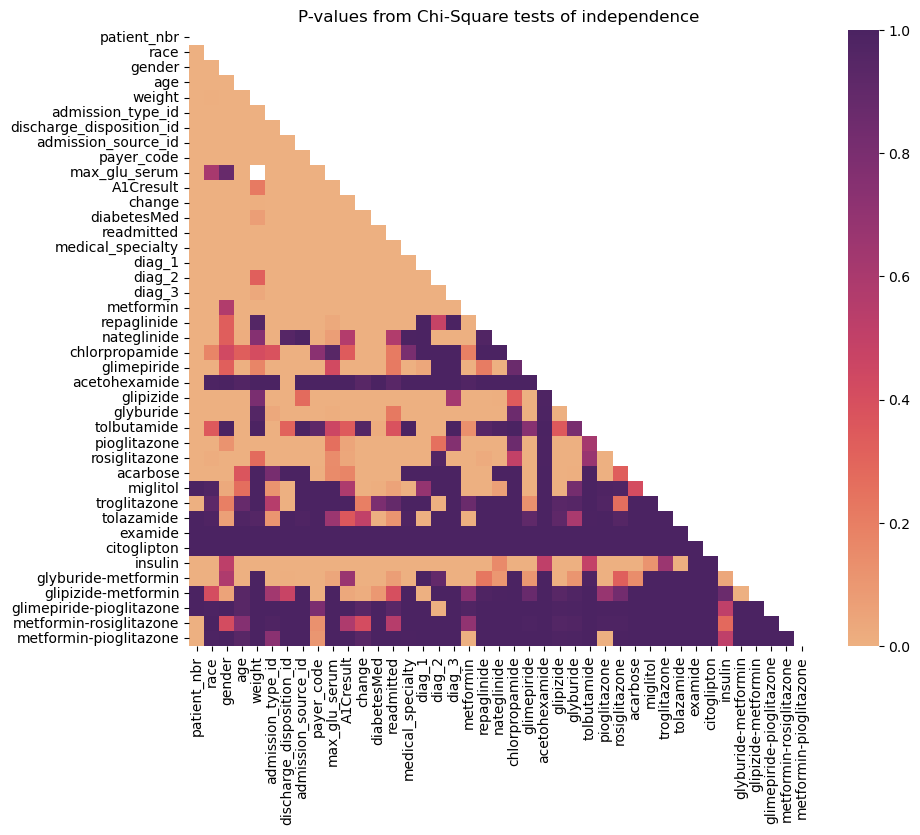

In [22]:
# Initialize a DataFrame to store the p-values
p_values = pd.DataFrame(index=cat_cols, columns=cat_cols)

for i in range(len(cat_cols)):
    for j in range(i+1, len(cat_cols)):
        col1 = cat_cols[i]
        col2 = cat_cols[j]
        contingency_table = pd.crosstab(diabetic_df[col1], diabetic_df[col2])
        if not contingency_table.empty:  # Check if the table is not empty
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            p_values.loc[col1, col2] = p
            p_values.loc[col2, col1] = p  # for symmetry

# Fill the diagonal with 1s
np.fill_diagonal(p_values.values, 1)
# Convert the data type to float
p_values = p_values.astype(float)

mask = np.triu(np.ones_like(p_values, dtype=bool))

plt.figure(figsize=(10, 8))  # size of the plot
sns.heatmap(p_values, annot=False, mask=mask, fmt=".2g", cmap='flare')
plt.title('P-values from Chi-Square tests of independence')
plt.show()


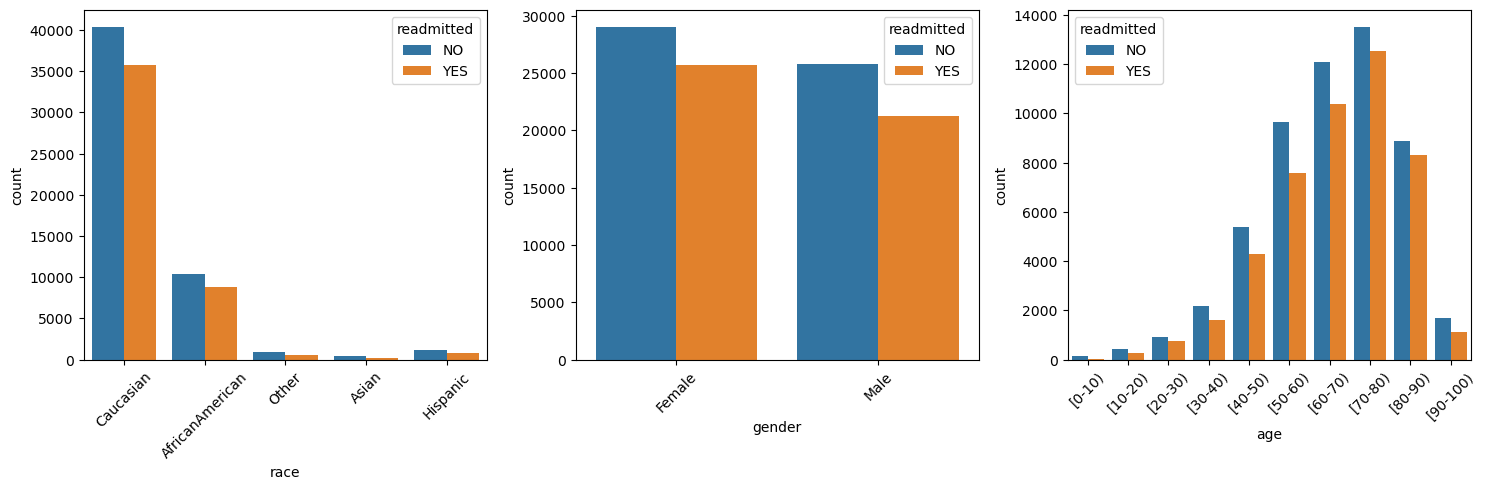

In [23]:
# Create a list of features
features = ['race', 'gender', 'age']

fig, axs = plt.subplots(nrows=1, ncols=len(features), figsize=(15, 5))

for i, feature in enumerate(features):
    sns.countplot(x=feature, hue='readmitted', data=diabetic_df, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


 # Task 2: Data assembling and initial pre-processing

 ## 2.1 Handle non-i.i.d. and drop columns

In [24]:
# Setup dataframe
df = diabetic_df.copy()

# Sort by encounter ID (potentially chronological) and remove later duplicate patients
df = df.sort_values('encounter_id')
# Create a mask for duplicated patient IDs
duplicates = df['patient_nbr'].duplicated(keep=False) # Marks all duplicates
# Drop duplicate rows based on patient_id
df = df.drop_duplicates(subset='patient_nbr')
# Drop columns 
df = df.drop(['encounter_id', 'payer_code', 'patient_nbr', 'weight', 'max_glu_serum', 'A1Cresult', 'medical_specialty'], axis=1) 

# Drop drug columns with below a certain threshold of positive values
# Create a mask for columns with less than 5 cumulative values of 'Down', 'Steady', or 'Up'
# Uses count_df from data visualization section
mask = (count_df.sum(axis=1) < 50)
removed_drugs = count_df[mask].index.tolist()
drug_cols = [col for col in drug_cols if col not in removed_drugs]
df = df.drop(mask[mask].index, axis=1) # Drop the columns where the mask is True

# Drop rows 
# Drop unknowns in gender, diag_1
df = df.dropna(subset=['gender', 'diag_1'])
# Drop hospice or death-related rows
df = df.loc[~df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21])]
df = df.loc[df['admission_source_id'] != 26]

 ## 2.2 Handle missing values

In [25]:
# Mask imputations for race
imp_columns = ['race']

for col in imp_columns:
    df[col + '_imputed'] = (df[col].isna()).astype(int)

df['race'].fillna(df['race'].mode().iloc[0], inplace=True)

# Rest of columns with missing values will be encoded as "Unknown" category so did not add a mask
unknown_cat_columns = ['diag_2', 'diag_3']

for col in unknown_cat_columns:
    df[col].fillna('?', inplace=True)


 ## 2.3 Set up encoding, scaling, etc.

In [26]:
# Encode target
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == "YES" else 0)


In [27]:
# Covert age to ordinal

# Define a function to calculate the midpoint of a range
def calculate_midpoint(range_values):
    bounds = range_values.strip('[]()').split('-')
    # Calculate and return midpoint
    return (float(bounds[0]) + float(bounds[1])) / 2
    
# Make age numeric
df['age'] = df['age'].apply(calculate_midpoint)

In [28]:
# Ordinal encoding in drug columns - manually before subsample is taken

# Define a dictionary to map the old values to the new values
replace_dict = {'No': 0, 'Down': 1, 'Steady': 2, 'Up': 3}

# Use the replace function to replace the values in the DataFrame
df[drug_cols] = df[drug_cols].replace(replace_dict)

In [29]:
# Define the bins and labels
bins = [-np.inf, 139, 239, 279, 289, 319, 389, 459, 519, 579, 629, 679, 709, 739, 759, 779, 799, 999, np.inf]
labels = ['[001 - 139]', '[140 - 239]', '[240 - 279]', '[280 - 289]', '[290 - 319]', '[320 - 389]', '[390 - 459]', '[460 - 519]', '[520 - 579]', '[580 - 629]', '[630 - 679]', '[680 - 709]', '[710 - 739]', '[740 - 759]', '[760 - 779]', '[780 - 799]', '[800 - 999]', 'E and V codes']

# Loop over the diagnosis columns
for i in range(1, 4):
    diag = f'diag_{i}'
    binned_diag = f'binned_diag_{i}'

    # Create a mask for codes that start with 'E' or 'V'
    mask_E = df[diag].str.startswith('E')
    mask_V = df[diag].str.startswith('V')
    mask_q = df[diag] == '?'

    # Copy over E, V or '?'
    df.loc[mask_E, binned_diag] = 'E'
    df.loc[mask_V, binned_diag] = 'V'
    df.loc[mask_q, binned_diag] = '?'
    
    # Create a mask for numeric codes
    mask_numeric = ~(mask_E | mask_V | mask_q)

    # Replace for masking (will drop these anyway)
    df.loc[mask_E, diag] = -1
    df.loc[mask_V, diag] = -1
    df.loc[mask_q, diag] = -1
    
    # Convert all to numeric
    df[diag] = pd.to_numeric(df[diag])
    mask_249_250 = (df[diag] >= 249) & (df[diag] < 251) # Create a mask for values between 249-251
    
    # Copy over to new columns
    df.loc[mask_249_250, binned_diag] = df.loc[mask_249_250, diag]
    

    # # Create the buckets for the numeric diagnoses, excluding 249-250 and -1's
    mask = df[binned_diag].isna() & ~mask_249_250
    df.loc[mask, binned_diag] = pd.cut(df.loc[mask_numeric, diag], bins=bins, labels=labels)
    
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)
    

In [30]:
unique_count_total = pd.concat([df['binned_diag_1'], df['binned_diag_2'], df['binned_diag_3']]).nunique()
print(f'Total number of unique categories across all three columns: {unique_count_total}')

unique_categories = pd.concat([df['binned_diag_1'], df['binned_diag_2'], df['binned_diag_3']]).unique()
print(f'Unique categories across all three columns: {unique_categories}')

Total number of unique categories across all three columns: 53
Unique categories across all three columns: ['[390 - 459]' '[140 - 239]' 250.7 '[460 - 519]' '[630 - 679]'
 '[800 - 999]' '[680 - 709]' '[710 - 739]' '[240 - 279]' '[520 - 579]' 'V'
 '[780 - 799]' '[580 - 629]' '[290 - 319]' '[001 - 139]' 250.6 250.4
 250.11 250.32 250.13 250.83 250.03 250.8 '[320 - 389]' 250.02 250.42
 250.41 250.22 250.82 '[280 - 289]' 250.33 250.12 250.81 250.93 250.0
 250.01 '[740 - 759]' 250.31 250.43 250.1 250.2 250.3 250.23 250.5 250.92
 250.21 250.9 250.52 250.51 250.91 250.53 'E' '?']


In [31]:
class OneHotEncodeAndAggregate(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Hardcoded list of unique categories
        self.categories_ = [250.83, '[240 - 279]', '[630 - 679]', '[001 - 139]', '[140 - 239]',
                            '[390 - 459]', 250.7, '[460 - 519]', '[800 - 999]', '[680 - 709]',
                            '[710 - 739]', '[520 - 579]', 'V', '[780 - 799]', '[580 - 629]', 
                            '[290 - 319]', 250.6, 250.4, 250.11, 250.32, 250.13, 250.03, 250.8, 
                            '[320 - 389]', 250.02, 250.42, 250.41, 250.22, 250.82, '[280 - 289]', 
                            250.33, 250.12, 250.81, 250.93, 250.0, 250.01, '[740 - 759]', 250.31, 
                            250.43, 250.1, 250.2, 250.3, 250.23, 250.5, 250.92, 250.21, 250.9, 
                            250.52, 250.51, 250.91, 250.53, 'E', '?']
        # Mapping of encoded columns back to original diagnosis codes will be initialized in fit
        self.mapping_ = None

    def fit(self, X, y=None):
        # Initialize the mapping dictionary based on the hardcoded categories
        self.mapping_ = {category: category for category in self.categories_}
        return self

    def transform(self, X):
        # One-hot encode all columns of X using pd.get_dummies
        dummies = pd.get_dummies(X, prefix='', prefix_sep='')
        
        # Ensure the output DataFrame has columns for all hardcoded categories, even if they're missing in transform
        missing_categories = set(self.categories_) - set(dummies.columns)
        for category in missing_categories:
            dummies[category] = 0  # Add missing categories with 0

        # Aggregate the one-hot encoded columns
        aggregated_dummies = dummies.groupby(dummies.columns, axis=1).max()

        # Ensure columns are in the same order as self.categories_
        aggregated_dummies = aggregated_dummies.reindex(columns=self.categories_, fill_value=0)

        return aggregated_dummies


    def get_mapping(self):
        # Provide the mapping
        return self.mapping_
    
    def get_feature_names_out(self, input_features=None):
        # Return the hardcoded categories as the feature names
        return self.categories_


In [32]:
# medication cols from above
one_hot_cols = ['race', 'gender', 'admission_type_id', 'change', 'diabetesMed']
target_cols_other = ['discharge_disposition_id', 'admission_source_id']
aggr_one_hot_cols = ['binned_diag_1', 'binned_diag_2', 'binned_diag_3']
scaled_cols = discrete_cols + drug_cols + ['age']

# Create transformers
one_hot_transformer = OneHotEncoder(drop='if_binary', handle_unknown = 'ignore')
aggr_one_hot_transformer = OneHotEncodeAndAggregate()
target_transformer = TargetEncoder(smooth=10)
min_max_transformer = MinMaxScaler()

# Update the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot_transformer, one_hot_cols),
        ('aggr_one_hot', aggr_one_hot_transformer, aggr_one_hot_cols),
        ('target', target_transformer, target_cols_other),
        ('scaler', min_max_transformer, scaled_cols)
    ], remainder='passthrough'
)

## 2.4 Create balanced subsample

In [33]:
race_counts = df['race'].value_counts()

print(race_counts)

race
Caucasian          54204
AfricanAmerican    12621
Hispanic            1498
Other               1149
Asian                488
Name: count, dtype: int64


In [34]:
# Filter the DataFrame to include only the 'Asian', 'Hispanic', and 'Other' races
minority_df = df[df['race'].isin(['Asian', 'Hispanic', 'Other'])]

# List of races to sample
races = ['Caucasian', 'AfricanAmerican']

# Initialize an empty list to store the sampled dataframes
sampled_dfs = []

# Sampling criteria - we sample more readmitted here to account for the imbalances in Asian, Hispanic and Other patients
not_readmitted_sample_size = 500
readmitted_sample_size = 1000

# Perform stratified sampling for each race by readmission status, gender, and age group
for race in races:
    for readmitted_status in [0, 1]:  # Assuming 'readmitted' column is binary, 0 for not readmitted, 1 for readmitted
        for gender in df['gender'].unique():  # Assuming 'gender' column contains gender information
            for age_group in df['age'].unique():  # Assuming 'age' column contains age group information

                # Filter the DataFrame to include only the current race, readmission status, gender, and age group
                subgroup_df = df[(df['race'] == race) & 
                                 (df['readmitted'] == readmitted_status) & 
                                 (df['gender'] == gender) & 
                                 (df['age'] == age_group)]

                # Determine the sample size based on readmission status
                sample_size = readmitted_sample_size if readmitted_status == 1 else not_readmitted_sample_size

                # Adjust sample size based on the number of unique gender-age groups
                n_groups = len(df['gender'].unique()) * len(df['age'].unique())
                sample_per_group = max(1, sample_size // n_groups)

                # Sample from the subgroup
                sampled_df = subgroup_df.sample(n=min(len(subgroup_df), sample_per_group), random_state=SEED)

                # Append the sampled dataframe to the list
                sampled_dfs.append(sampled_df)

# Concatenate the sampled dataframes with the minority dataframe
subsample_df = pd.concat([minority_df] + sampled_dfs, ignore_index=True)

# Reset the index of the final DataFrame (might be redundant due to ignore_index=True in concat)
subsample_df.reset_index(drop=True, inplace=True)

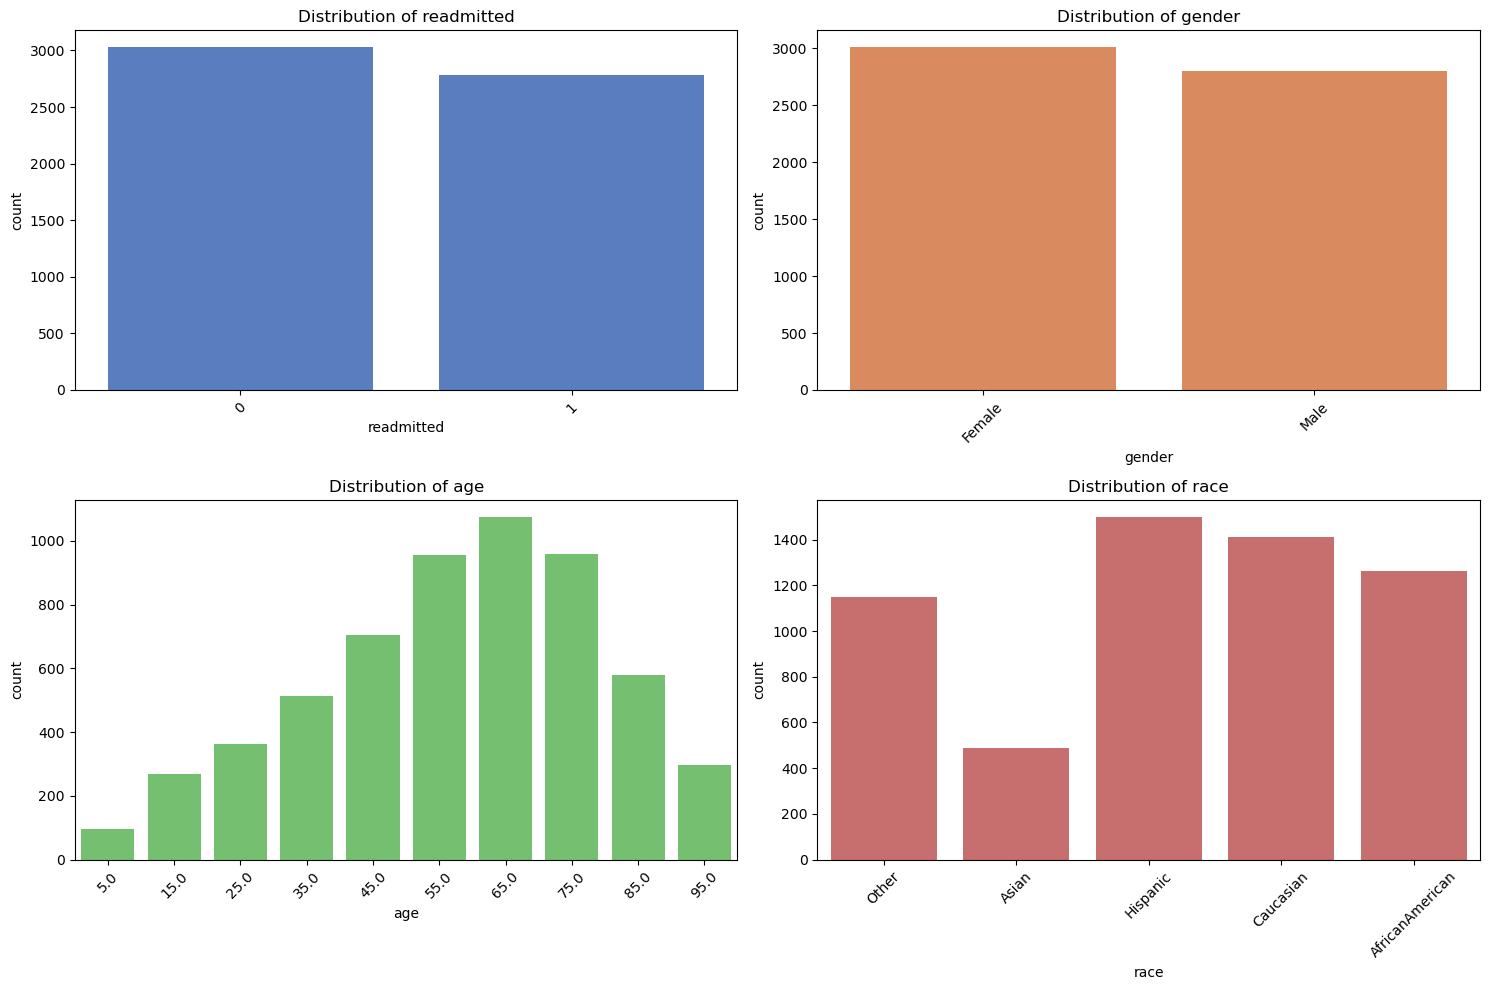

In [35]:
# List of columns to visualize
cols = ['readmitted', 'gender', 'age', 'race']

# Create a figure with 4 subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Flatten the axes
axs = axs.flatten()

# Create a color palette
palette = sns.color_palette("muted", n_colors=len(cols))

# Create a bar chart for each column
for i, col in enumerate(cols):
    sns.countplot(x=col, data=subsample_df, ax=axs[i], color=palette[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()

# Show the figure
plt.show()

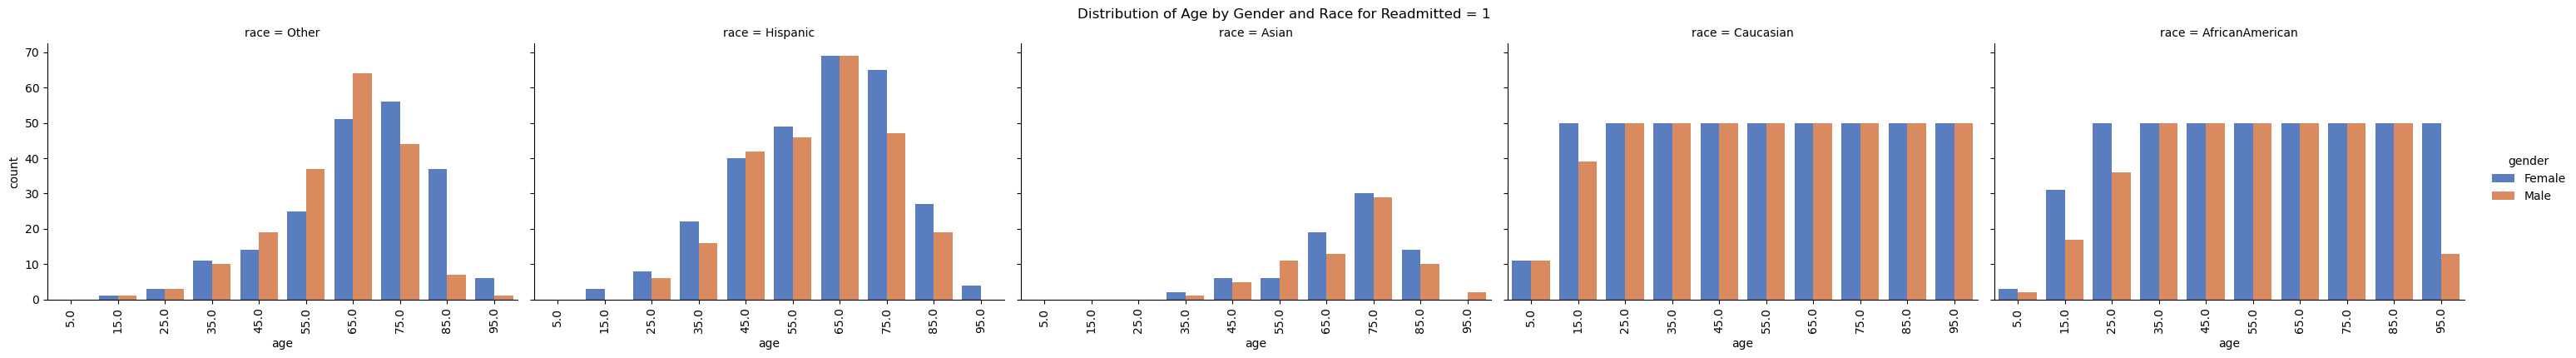

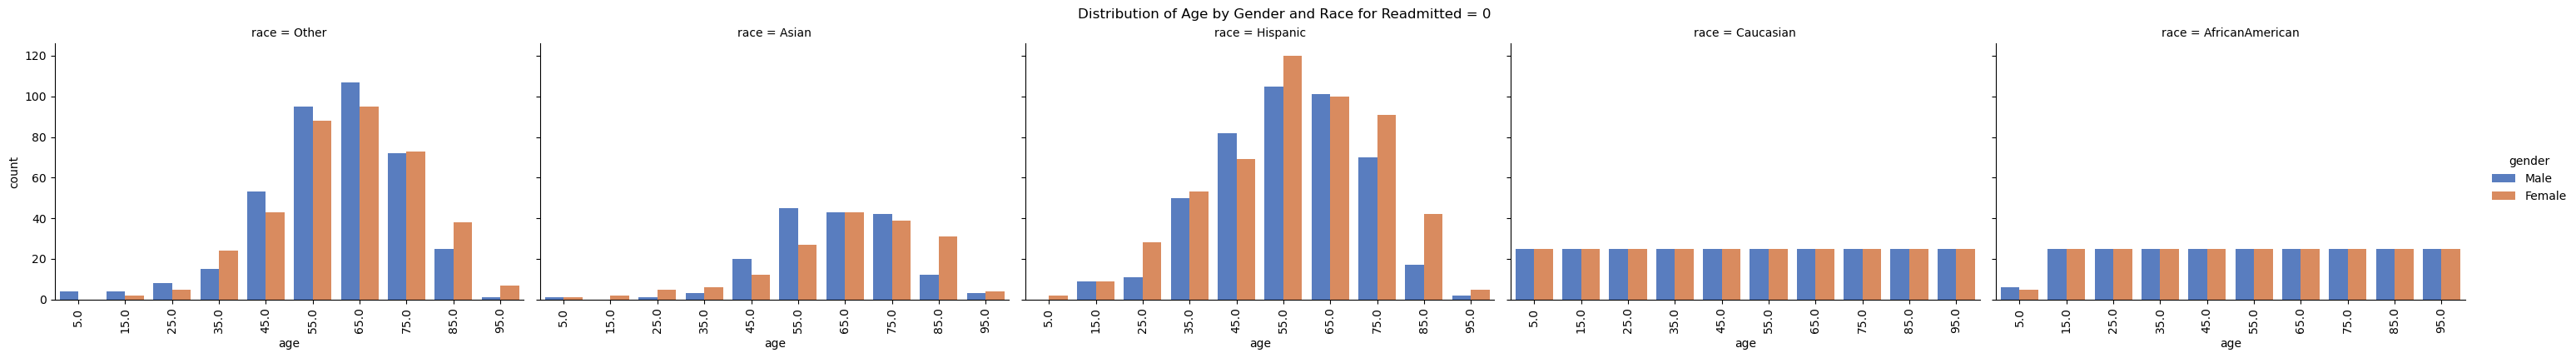

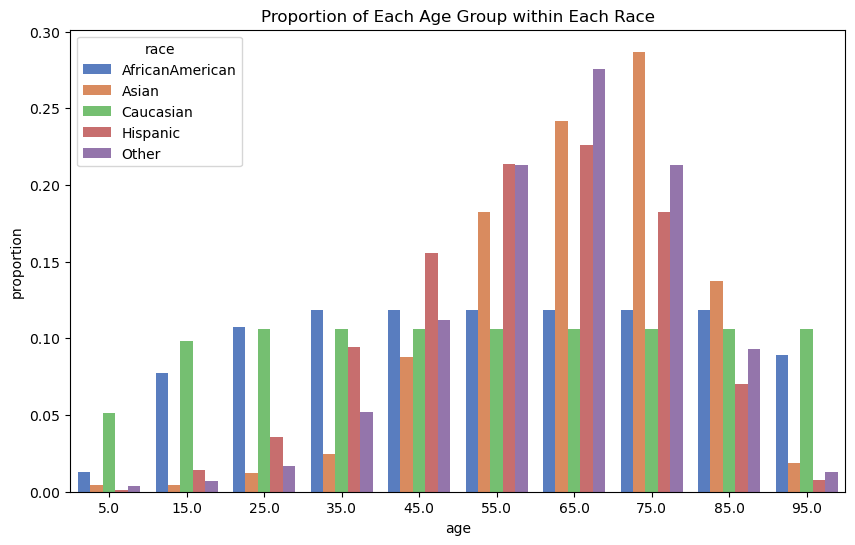

In [36]:
# Explore distribution of demographics by admitted/readmitted

# Filter the DataFrame for 'readmitted' = 1
subsample_df_readmitted = subsample_df[subsample_df['readmitted'] == 1]

# Create a categorical plot of 'age' by 'gender' and 'race' for 'readmitted' = 1
g = sns.catplot(x="age", hue="gender", col="race", data=subsample_df_readmitted, kind="count", height=4, aspect=1.5, palette='muted')
g.set_xticklabels(rotation=90)
plt.suptitle('Distribution of Age by Gender and Race for Readmitted = 1', y=1.02)
plt.show()

# Filter the DataFrame for 'readmitted' = 0
subsample_df_not_readmitted = subsample_df[subsample_df['readmitted'] == 0]

# Create a categorical plot of 'age' by 'gender' and 'race' for 'readmitted' = 0
g = sns.catplot(x="age", hue="gender", col="race", data=subsample_df_not_readmitted, kind="count", height=4, aspect=1.5, palette='muted')
g.set_xticklabels(rotation=90)
plt.suptitle('Distribution of Age by Gender and Race for Readmitted = 0', y=1.02)
plt.show()

# Calculate the proportion of each age group within each race
race_age_counts = subsample_df.groupby(['race', 'age']).size()
race_counts = subsample_df.groupby('race').size()
proportions = race_age_counts / race_counts

# Convert the proportions Series to a DataFrame and reset the index
proportions = proportions.reset_index(name='proportion')

# Plot the proportions
plt.figure(figsize=(10,6))
sns.barplot(x='age', y='proportion', hue='race', data=proportions, palette='muted')
plt.title('Proportion of Each Age Group within Each Race')
plt.show()

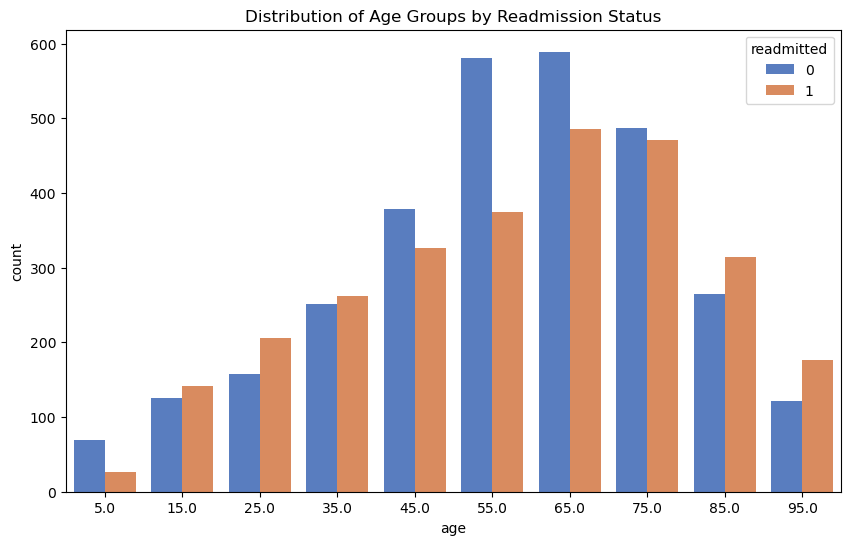

In [37]:
plt.figure(figsize=(10,6))
sns.countplot(x='age', hue='readmitted', data=subsample_df, palette='muted')
plt.title('Distribution of Age Groups by Readmission Status')
plt.show()

In [38]:
subsample_df.shape

(5809, 33)

In [39]:
# Set the number of rows to display
pd.set_option('display.max_rows', 5)

# Set the number of columns to display to None, which means all will be displayed
pd.set_option('display.max_columns', None)

In [40]:
subsample_df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,insulin,glyburide-metformin,change,diabetesMed,readmitted,race_imputed,binned_diag_1,binned_diag_2,binned_diag_3
0,Other,Female,55.0,1,1.0,7.0,1,33,0,7,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,No,Yes,0,0,[780 - 799],[390 - 459],250.0
1,Other,Male,65.0,2,1.0,4.0,5,64,4,14,0,0,0,9,0,0,0,0,0,2,0,0,0,0,1,0,Ch,Yes,1,0,[390 - 459],[390 - 459],[580 - 629]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5807,AfricanAmerican,Male,5.0,1,1.0,1.0,2,55,0,6,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,No,Yes,1,0,250.11,[780 - 799],?
5808,AfricanAmerican,Male,5.0,2,1.0,1.0,4,53,0,5,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,No,Yes,1,0,250.11,V,?


In [41]:


# Perform the train-test split, stratifying by age
X_train, X_test, y_train, y_test = train_test_split(subsample_df.drop('readmitted', axis=1), subsample_df['readmitted'], stratify=subsample_df['age'], test_size=0.2, random_state=42)

# Calculate the proportion of each class in the target variable for the original dataset, training set, and test set
original_proportions = subsample_df['readmitted'].value_counts(normalize=True)
train_proportions = y_train.value_counts(normalize=True)
test_proportions = y_test.value_counts(normalize=True)

# Print the proportions
print('Original proportions:\n', original_proportions)
print('Training set proportions:\n', train_proportions)
print('Test set proportions:\n', test_proportions)
print(X_train.shape, X_test.shape)

Original proportions:
 readmitted
0    0.520916
1    0.479084
Name: proportion, dtype: float64
Training set proportions:
 readmitted
0    0.515817
1    0.484183
Name: proportion, dtype: float64
Test set proportions:
 readmitted
0    0.541308
1    0.458692
Name: proportion, dtype: float64
(4647, 32) (1162, 32)


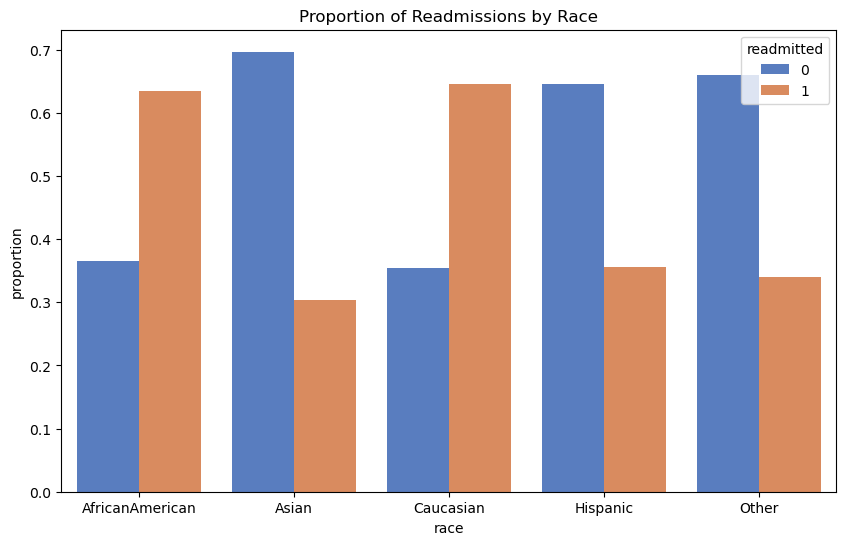

In [42]:
# Calculate the proportion of readmissions for each race - added this section after seeing interpretation section results
# This is problematic for our model
readmission_counts = subsample_df.groupby(['race', 'readmitted']).size()
race_counts = subsample_df.groupby('race').size()
readmission_proportions = readmission_counts / race_counts

# Convert the proportions Series to a DataFrame and reset the index
readmission_proportions = readmission_proportions.reset_index(name='proportion')

# Create a bar plot of readmission proportions by race
plt.figure(figsize=(10,6))
sns.barplot(x='race', y='proportion', hue='readmitted', data=readmission_proportions, palette='muted')
plt.title('Proportion of Readmissions by Race')
plt.show()

# Task 3: Design and build a machine learning pipeline

## 3.1 Cross-validation pipeline

### 3.1.1 Define models and hyperparameter tune

In [43]:
# For additional tracking of metrics
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity

In [44]:
# Note that warnings relate to the use of our custom OneHotEncoder class - while we adjust for unseen categories directly in the class, 
# the warning message appears before this adjustment is applied.  It can be disregarded.

# Here we define the parameters for hyperparameter tuning, initialize models, design and apply our pipeline to all selected models


SVM_linear_params = {
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

SVM_params = {
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

RF_params = {
    'classifier__n_estimators': [50, 100, 200, 500, 1000],  
    'classifier__max_depth': [None, 5, 20, 50]
}

XGB_params = {
    'classifier__n_estimators': [50, 100, 200, 500, 1000], 
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.3],
    'classifier__max_depth': [None, 5, 20, 50]
}

models = {
    'Linear SVM': (SVC(kernel="linear"), SVM_linear_params),
    'RBF SVM': (SVC(kernel="rbf"), SVM_params), 
    'RF': (RandomForestClassifier(), RF_params),
    'XGB': (XGBClassifier(), XGB_params)

}

scoring = { # We tracked additional metrics in case later analysis was required
    'roc_auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'f2': make_scorer(fbeta_score, beta=2),
    'precision': make_scorer(precision_score, zero_division=1),
    'recall': make_scorer(recall_score),  
    'specificity': make_scorer(specificity_score),
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

grid_results = {}



for model in models:

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', models[model][0])
    ])
    
    grid_search = GridSearchCV(
        estimator = pipeline,
        param_grid = models[model][1],
        scoring = scoring,
        refit = "f2",
        pre_dispatch = 6,
        n_jobs=6,
        error_score=0,
        cv = cv,
        verbose=1,
    )
    grid_results[model] = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/angelinamagal/miniconda3/envs/comp0189/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/angelinamagal/miniconda3/envs/comp0189/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/angelinamagal/miniconda3/envs/comp0189/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/angelinamagal/miniconda3/envs/comp0189/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/angelinamagal/miniconda3/envs/comp0189/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 80 candidates, totalling 400 fits


/Users/angelinamagal/miniconda3/envs/comp0189/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [45]:
# Initialize an empty list to store the results
cv_results = []

# Loop over each model in grid_results
for model, grid in grid_results.items():
    cv_results.append({
        'Model': model,
        'Mean F2': grid.cv_results_['mean_test_f2'].mean(),
        'Std Dev F2': grid.cv_results_['std_test_f2'].mean(),
        'Mean Accuracy': grid.cv_results_['mean_test_accuracy'].mean(),
        'Std Dev Accuracy': grid.cv_results_['std_test_accuracy'].mean(),
        'Best Parameters': grid.best_params_
    })

# Create a DataFrame from the results
cv_results_df = pd.DataFrame(cv_results).round(3)

# Set the display option to show the full content of DataFrame columns
pd.set_option('display.max_colwidth', None)

# Print the DataFrame
cv_results_df

,Model,Mean F2,Std Dev F2,Mean Accuracy,Std Dev Accuracy,Best Parameters
0,Linear SVM,0.619,0.017,0.649,0.014,{'classifier__C': 0.01}
1,RBF SVM,0.393,0.014,0.592,0.010,"{'classifier__C': 0.1, 'classifier__gamma': 0.1}"
2,RF,0.634,0.015,0.660,0.016,"{'classifier__max_depth': 20, 'classifier__n_estimators': 500}"
3,XGB,0.577,0.021,0.627,0.017,"{'classifier__learning_rate': 0.01, 'classifier__max_depth': None, 'classifier__n_estimators': 500}"


In [46]:
cv_results_df.to_csv('CV_val_results.csv', index=True)

### 3.1.2. Test models

In [47]:
test_results = {
    'Test F2 Score': {},
    'Test Accuracy': {},

}

for model_name, grid_search in grid_results.items():
    # Get the best model from grid search
    model = grid_search.best_estimator_
    
    # Predict on the test data
    y_pred = model.predict(X_test)
        # Print the predictions
    
    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)

    f2 = fbeta_score(y_test, y_pred, beta=2)

    # Calculate specificity
    
    # Save the results
    test_results['Test F2 Score'][model_name] = f2
    test_results['Test Accuracy'][model_name] = accuracy





In [48]:
df_test_results = pd.DataFrame(test_results)

# Round to 3 decimal places
df_test_results = df_test_results.round(3)
df_test_results.to_csv('CV_test_results.csv', index=True)

df_test_results

,Test F2 Score,Test Accuracy
Linear SVM,0.615,0.652
RBF SVM,0.615,0.652
RF,0.656,0.674
XGB,0.633,0.665


## 3.2 Performance evaluation

### 3.2.1. Visualise hyperparameters

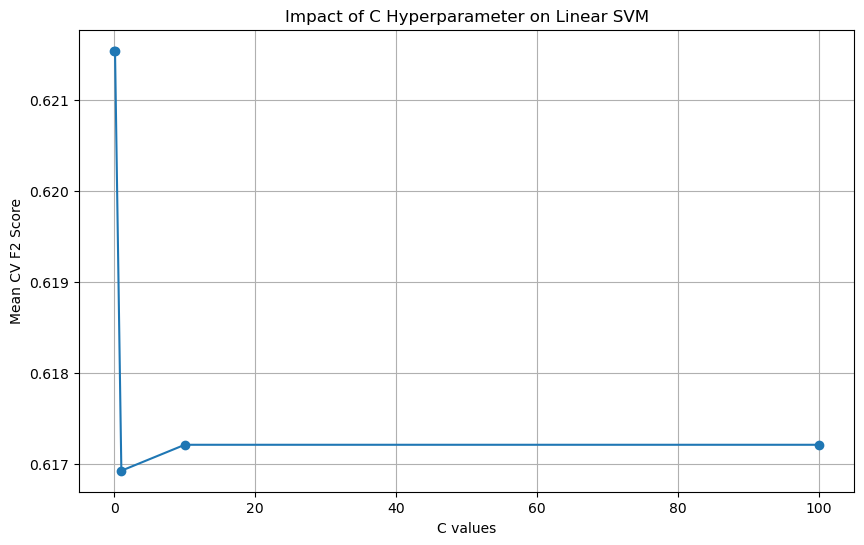

In [49]:


# Get the cross-validation results
cv_results = grid_results['Linear SVM'].cv_results_

# Get the mean test F2 scores for each hyperparameter combination
mean_test_scores = cv_results['mean_test_f2']

# Get the values of the C hyperparameter for each combination
C_values = cv_results['param_classifier__C']

# Create a line plot of C values vs F2 scores
plt.figure(figsize=(10, 6))
plt.plot(C_values, mean_test_scores, marker='o')  # Use plot instead of scatter
plt.xlabel('C values')
plt.ylabel('Mean CV F2 Score')
plt.title('Impact of C Hyperparameter on Linear SVM')
plt.grid(True)
plt.show()

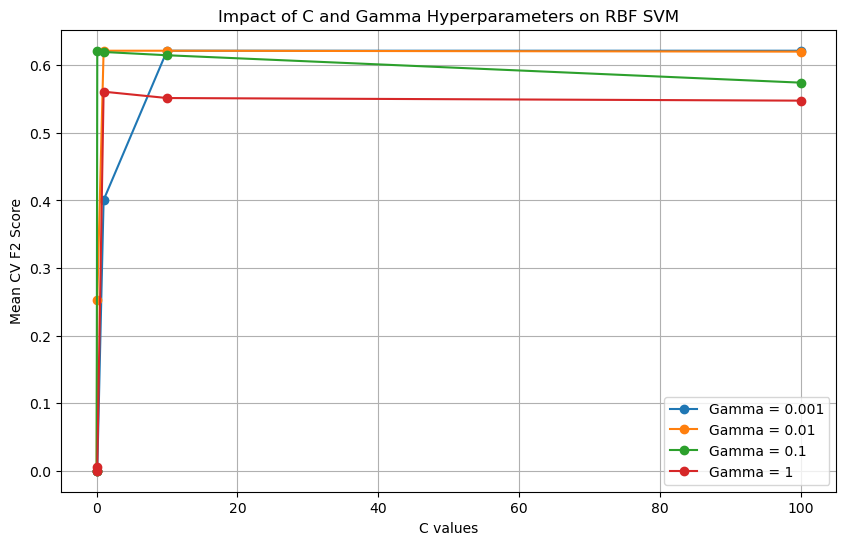

In [50]:


# Get the cross-validation results
cv_results = grid_results['RBF SVM'].cv_results_

# Get the mean test F2 scores for each hyperparameter combination
mean_test_scores = cv_results['mean_test_f2']

# Get the values of the C and gamma hyperparameters for each combination
C_values = cv_results['param_classifier__C'].data
gamma_values = cv_results['param_classifier__gamma'].data

# Get the unique gamma values
unique_gamma_values = np.unique(gamma_values)

# Create a 2D plot of C values vs F2 scores for each gamma value
plt.figure(figsize=(10, 6))

for gamma in unique_gamma_values:
    # Get the indices where gamma is equal to the current gamma value
    indices = np.where(gamma_values == gamma)
    
    # Get the corresponding C values and test scores
    C_values_gamma = C_values[indices]
    test_scores_gamma = mean_test_scores[indices]
    
    # Plot the C values against the test scores
    plt.plot(C_values_gamma, test_scores_gamma, marker='o', label=f'Gamma = {gamma}')

plt.xlabel('C values')
plt.ylabel('Mean CV F2 Score')
plt.title('Impact of C and Gamma Hyperparameters on RBF SVM')
plt.legend()
plt.grid(True)
plt.show()

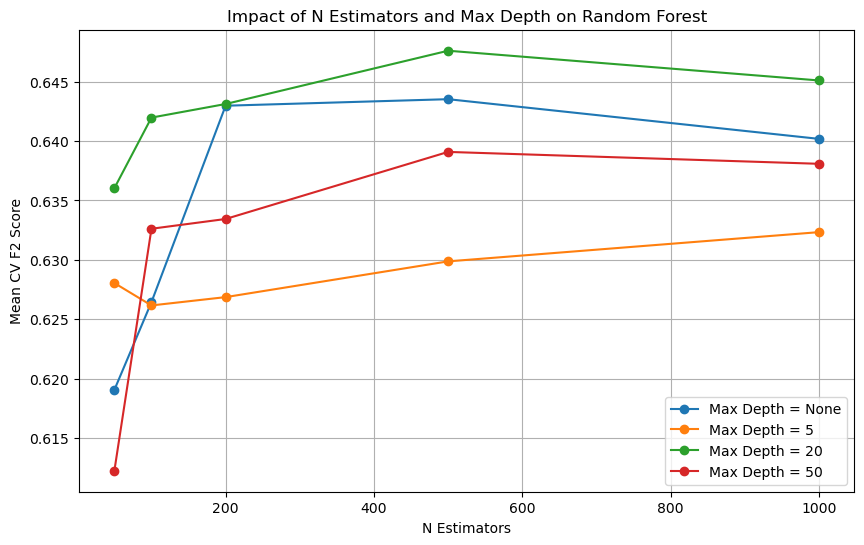

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the cross-validation results for Random Forest
cv_results_rf = grid_results['RF'].cv_results_

# Create a DataFrame with the mean test F2 scores, n_estimators values, and max_depth values
df_rf = pd.DataFrame({
    'mean_test_f2': cv_results_rf['mean_test_f2'],
    'n_estimators': cv_results_rf['param_classifier__n_estimators'],
    'max_depth': cv_results_rf['param_classifier__max_depth']
})

# Replace None with the string 'None' for plotting
df_rf['max_depth'] = df_rf['max_depth'].where(df_rf['max_depth'].notnull(), 'None')

# Create a 2D plot of n_estimators values vs F2 scores for each max_depth value
plt.figure(figsize=(10, 6))

# Get the unique max_depth values
unique_max_depth_values_rf = df_rf['max_depth'].unique()

# Plot the n_estimators values against the test scores for each max_depth value
for max_depth in unique_max_depth_values_rf:
    # Filter the DataFrame for the current max_depth value
    df_rf_max_depth = df_rf[df_rf['max_depth'] == max_depth]
    
    # Plot the n_estimators values against the test scores
    plt.plot(df_rf_max_depth['n_estimators'], df_rf_max_depth['mean_test_f2'], marker='o', label=f'Max Depth = {max_depth}')

plt.xlabel('N Estimators')
plt.ylabel('Mean CV F2 Score')
plt.title('Impact of N Estimators and Max Depth on Random Forest')
plt.legend()
plt.grid(True)
plt.show()

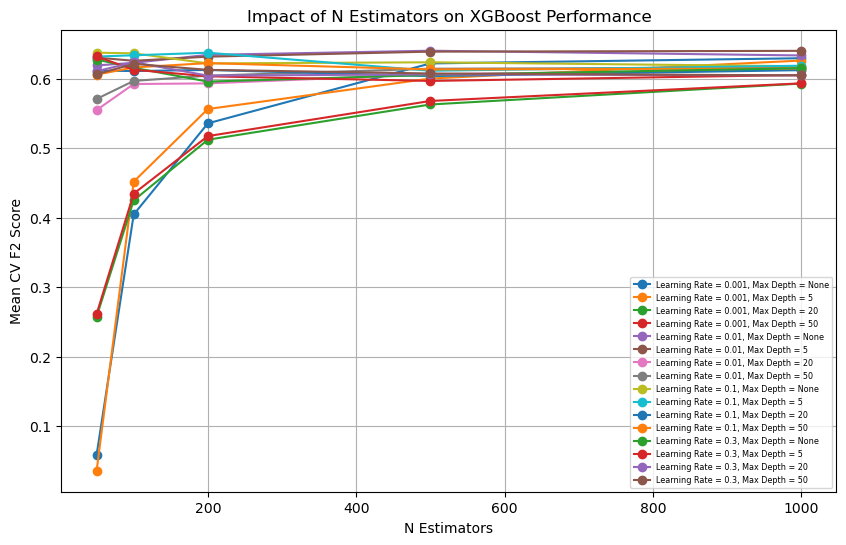

In [52]:


cv_results_xgb = grid_results['XGB'].cv_results_

# Extract parameter values and test scores
lr_values_xgb = cv_results_xgb['param_classifier__learning_rate']
max_depth_values_xgb = cv_results_xgb['param_classifier__max_depth']
n_estimators_values_xgb = cv_results_xgb['param_classifier__n_estimators']
mean_test_scores_xgb = cv_results_xgb['mean_test_f2']

# Initialize a plot
plt.figure(figsize=(10, 6))

# Create a set to track plotted combinations to avoid duplication
plotted_combinations = set()

# Iterate through all entries
for lr, depth, n_est, score in zip(lr_values_xgb, max_depth_values_xgb, n_estimators_values_xgb, mean_test_scores_xgb):
    # Create a unique identifier for each combination of learning_rate and max_depth
    combination = (lr, depth)
    
    # Check if this combination has been plotted
    if combination not in plotted_combinations:
        # Filter data for the current combination
        indices = np.where((lr_values_xgb == lr) & (max_depth_values_xgb == depth))
        filtered_n_est = n_estimators_values_xgb[indices]
        filtered_scores = mean_test_scores_xgb[indices]
        
        # Sort by n_estimators for a smooth line
        sorted_indices = np.argsort(filtered_n_est)
        sorted_n_est = np.array(filtered_n_est)[sorted_indices]
        sorted_scores = np.array(filtered_scores)[sorted_indices]
        
        # Plot
        plt.plot(sorted_n_est, sorted_scores, marker='o', label=f'Learning Rate = {lr}, Max Depth = {depth}')
        
        # Mark this combination as plotted
        plotted_combinations.add(combination)

# Finalize plot
plt.xlabel('N Estimators')
plt.ylabel('Mean CV F2 Score')
plt.title('Impact of N Estimators on XGBoost Performance')
plt.legend(loc='lower right', fontsize='xx-small')
plt.grid(True)
plt.show()

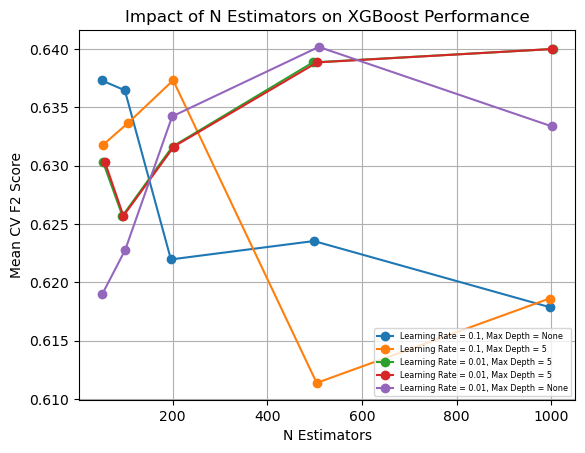

In [53]:
# Convert parameter values and test scores to numpy arrays
lr_values_xgb = np.array(lr_values_xgb)
max_depth_values_xgb = np.array(max_depth_values_xgb)
n_estimators_values_xgb = np.array(n_estimators_values_xgb)
mean_test_scores_xgb = np.array(mean_test_scores_xgb)

# Get indices of top 5 models
top_5_indices = np.argsort(mean_test_scores_xgb)[-5:]

# Iterate through top 5 models
for index in top_5_indices:
    # Get parameters and score of current model
    lr = lr_values_xgb[index]
    depth = max_depth_values_xgb[index]
    n_est = n_estimators_values_xgb[index]
    score = mean_test_scores_xgb[index]

    # Filter data for the current combination
    indices = np.where((lr_values_xgb == lr) & (max_depth_values_xgb == depth))
    filtered_n_est = n_estimators_values_xgb[indices]
    filtered_scores = mean_test_scores_xgb[indices]

    # Sort by n_estimators for a smooth line
    sorted_indices = np.argsort(filtered_n_est)
    sorted_n_est = np.array(filtered_n_est)[sorted_indices]
    sorted_scores = np.array(filtered_scores)[sorted_indices]

    # Plot
    # Plot with noise
    plt.plot(sorted_n_est + np.random.normal(scale=5, size=len(sorted_n_est)), sorted_scores, marker='o', label=f'Learning Rate = {lr}, Max Depth = {depth}')

# Finalize plot
plt.xlabel('N Estimators')
plt.ylabel('Mean CV F2 Score')
plt.title('Impact of N Estimators on XGBoost Performance')
plt.legend(loc='lower right', fontsize='xx-small')
plt.grid(True)
plt.show()

### 3.2.2. Visualise overall

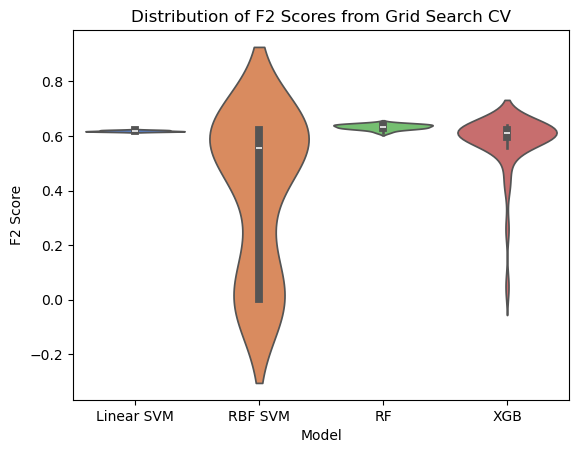

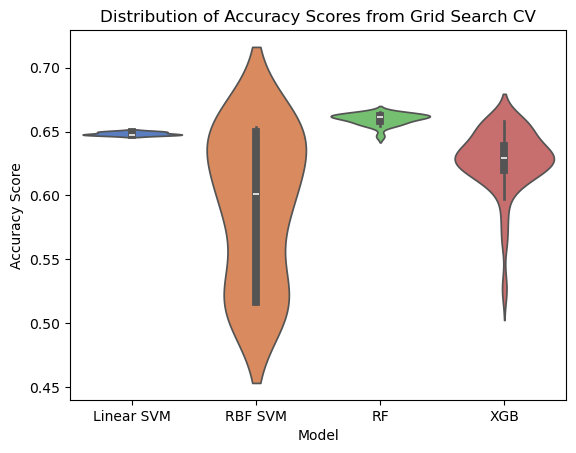

In [54]:
# Extract the F2 scores and accuracy from the cv_results_ attribute of each grid search
cv_scores_f2 = {model: grid.cv_results_['mean_test_f2'] for model, grid in grid_results.items()}
cv_scores_accuracy = {model: grid.cv_results_['mean_test_accuracy'] for model, grid in grid_results.items()}

# Convert the dictionaries to DataFrames
df_f2 = pd.DataFrame.from_dict(cv_scores_f2, orient='index').transpose()
df_accuracy = pd.DataFrame.from_dict(cv_scores_accuracy, orient='index').transpose()

# Create violin plots of the scores
for df, score in [(df_f2, 'F2'), (df_accuracy, 'Accuracy')]:
    sns.violinplot(data=df, palette="muted")

    # Set the title and labels
    plt.title(f'Distribution of {score} Scores from Grid Search CV')
    plt.xlabel('Model')
    plt.ylabel(f'{score} Score')

    # Show the plot
    plt.show()

In [55]:
# Set the display option to show the full content of DataFrame columns
pd.reset_option('display.max_colwidth')


# Task 4: Model Interpretation

## 4.1 Tree-based models

In [56]:
# List of models
models_features = ['RF', 'XGB']

# Create an empty dictionary to store feature importances for all models
all_feature_importances = {}

for model_name in models_features:
    # Get the best estimator for the current model
    fitted_pipeline = grid_results[model_name].best_estimator_
    transformed_features = fitted_pipeline.named_steps['preprocessor'].get_feature_names_out()

    # Get the model from the pipeline
    model = fitted_pipeline.named_steps['classifier']

    # Get the feature importances
    feature_importances = model.feature_importances_

    # Store the feature importances in the dictionary
    all_feature_importances[model_name] = {
        'Feature': transformed_features,
        'Importance': feature_importances,
    }

In [57]:
# Select the top N features for each model
N = 10

# Create a dictionary to store the top features for each model
top_features = {}

for model_name in models_features:
    # Get the feature importances for the current model
    feature_importances = all_feature_importances[model_name]

    # Create a DataFrame with feature names and importances
    feature_importances_df = pd.DataFrame({
        'Feature': feature_importances['Feature'],
        'Importance': feature_importances['Importance'],
    })

    # Sort the DataFrame by importance in descending order
    feature_importances_df.sort_values('Importance', ascending=False, inplace=True)

    # Select the top N features
    top_features[model_name] = feature_importances_df['Feature'].head(N).tolist()

top_features_set = set(top_features['XGB'] + top_features['RF'])

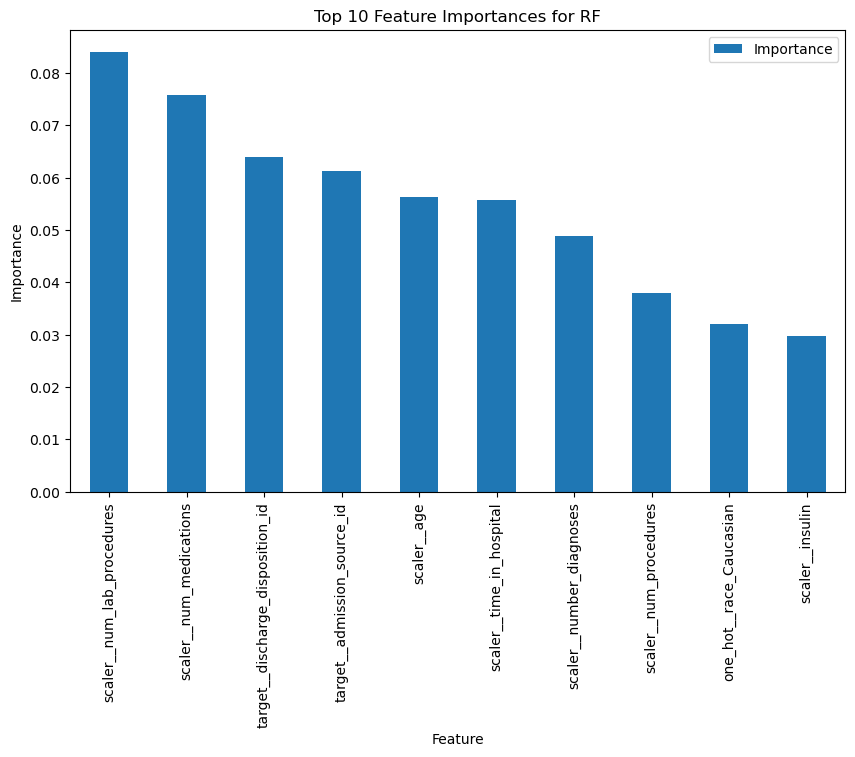

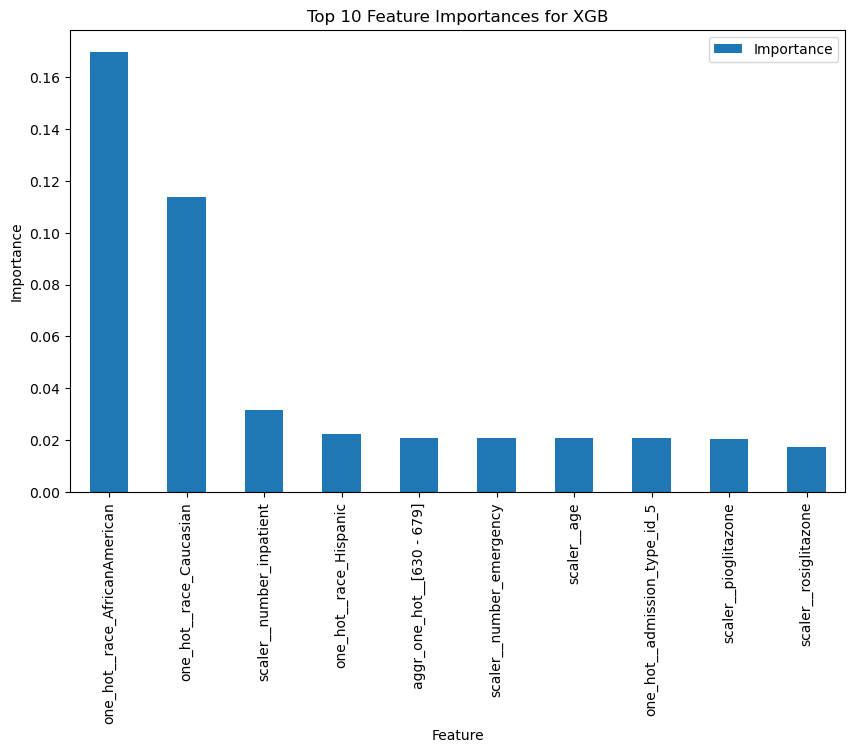

In [58]:


# Flatten the nested dictionary into a DataFrame
df = pd.concat({k: pd.DataFrame(v).set_index('Feature') for k, v in all_feature_importances.items()}, axis=0)

# Reset the index and rename the columns
df.reset_index(inplace=True)
df.columns = ['Model', 'Feature', 'Importance']

for model_name in models_features:
    
# Filter the DataFrame to only include the top features for the current model
    df_model = df[(df['Feature'].isin(top_features[model_name])) & (df['Model'] == model_name)].copy()

    # Sort the DataFrame by importance in descending order
    df_model.sort_values('Importance', ascending=False, inplace=True)

    # Plot a bar chart
    df_model.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))

    plt.title('Top {} Feature Importances for {}'.format(N, model_name))
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()

## 4.2 Linear SVM

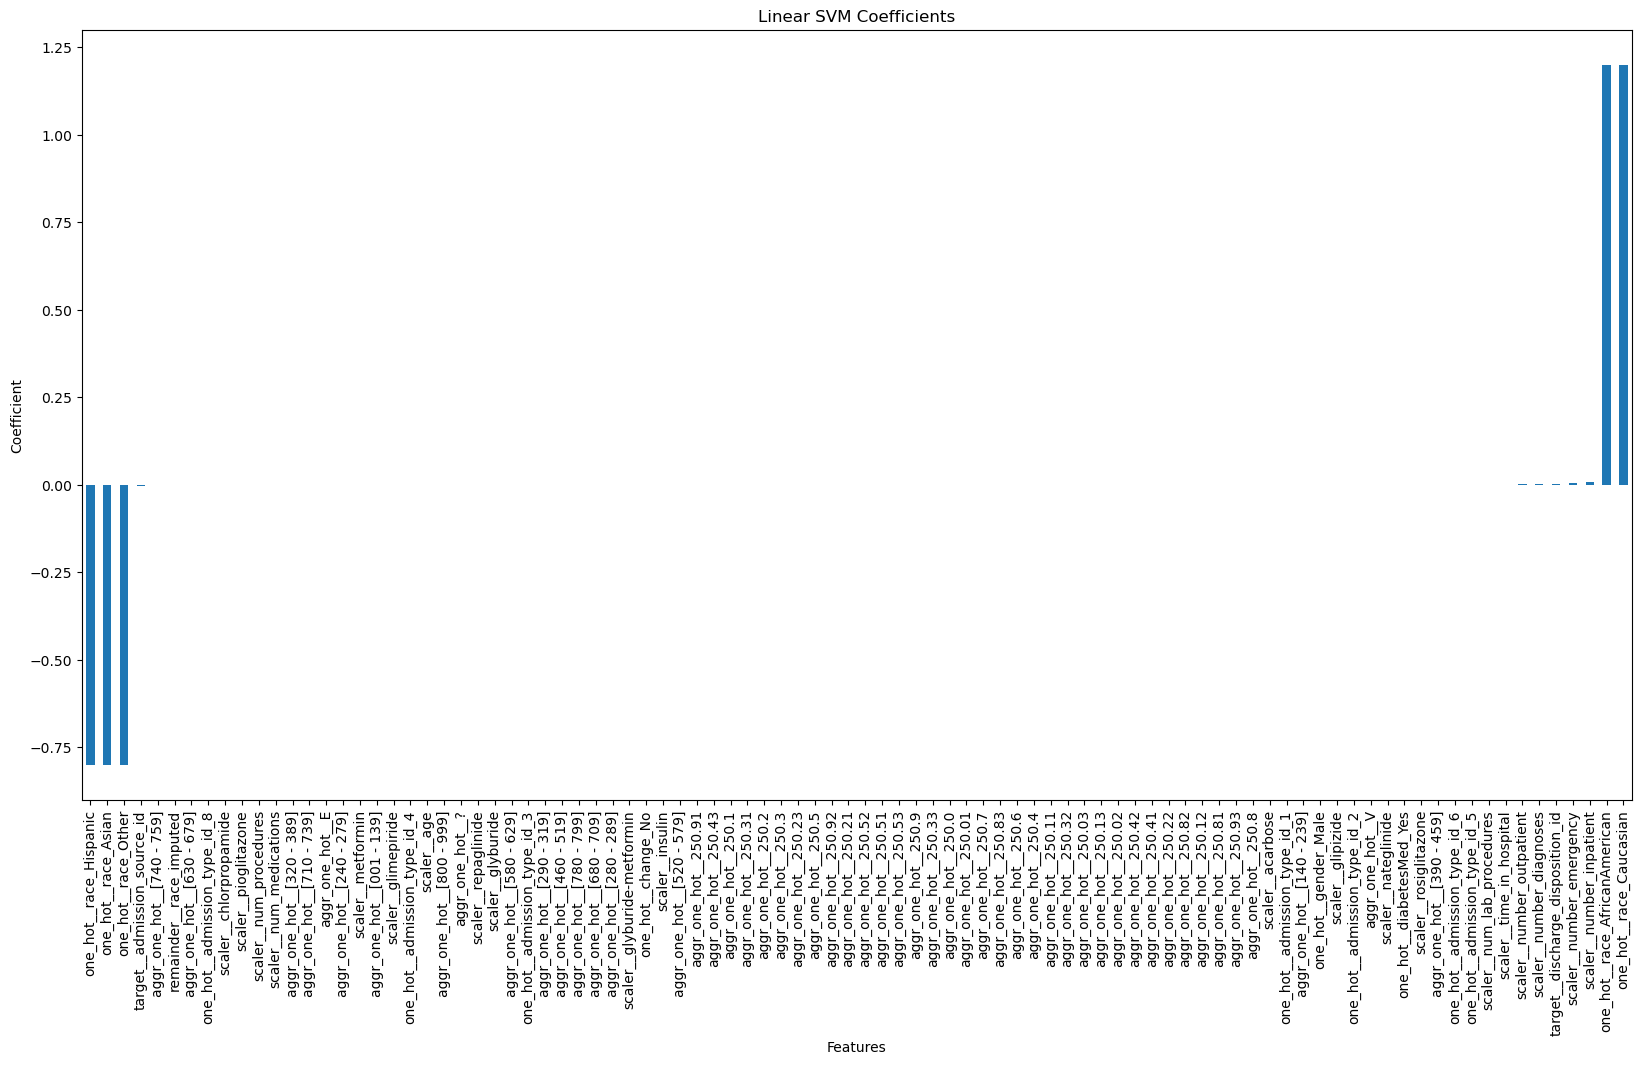

In [59]:
# Get the best Linear SVM model from grid search
best_linear_svm_model = grid_results['Linear SVM'].best_estimator_

# Get the coefficients
coef = best_linear_svm_model.named_steps['classifier'].coef_

# Convert the coefficients to a DataFrame
linear_SVM_coef_df = pd.DataFrame(coef, columns=transformed_features)

# Sort the DataFrame by the coefficients
linear_SVM_coef_df_sorted = linear_SVM_coef_df.sort_values(by=0, axis=1)

# Plot the sorted coefficients
linear_SVM_coef_df_sorted.T.plot(kind='bar', legend=False, figsize=(20, 10))
plt.title('Linear SVM Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()

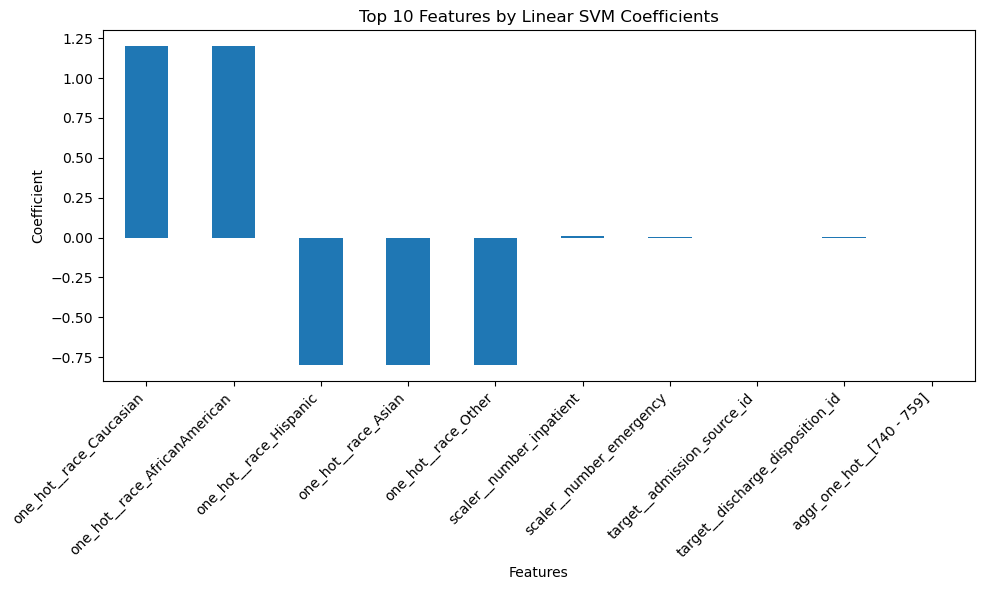

In [60]:
# Sort by absolute value but keep the original sign
sorted_coef = linear_SVM_coef_df.T[0].sort_values(key=abs, ascending=False)

# Get the top 10 features
top_features_SVM_coef = sorted_coef.head(10)
# Get the feature names
top_10_svm_features = top_features_SVM_coef.index.tolist()

# Store the feature names in the top_features dictionary
top_features['Linear SVM'] = top_10_svm_features

# Plot the coefficients of the top 10 features
ax = top_features_SVM_coef.plot(kind='bar', figsize=(10, 6))

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Set the title and labels
plt.title('Top 10 Features by Linear SVM Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient')

# Show the plot
plt.tight_layout()
plt.show()

## 4.3 All model comparison

In [61]:
# Initialize an empty dictionary to store the results
perm_importances = {}

for model_name, grid_search in grid_results.items():
    # Get the best model from grid search
    model = grid_search.best_estimator_

    preprocessor = model.named_steps['preprocessor']

    result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=SEED, n_jobs=6)
    sorted_idx = result.importances_mean.argsort()

    # Create a DataFrame with the feature names, their importances, and standard deviations
    df = pd.DataFrame({
        'feature': X_test.columns[sorted_idx],
        'importance': result.importances_mean[sorted_idx],
        'std_dev': result.importances_std[sorted_idx]
    })

    # Store the DataFrame in the dictionary
    perm_importances[model_name] = df

/Users/angelinamagal/miniconda3/envs/comp0189/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


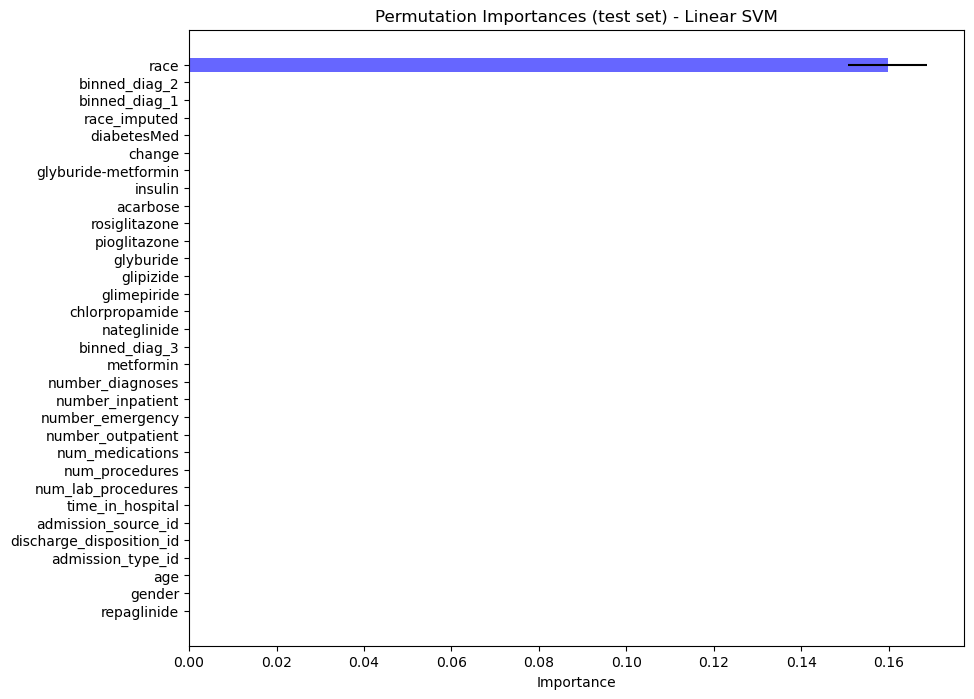

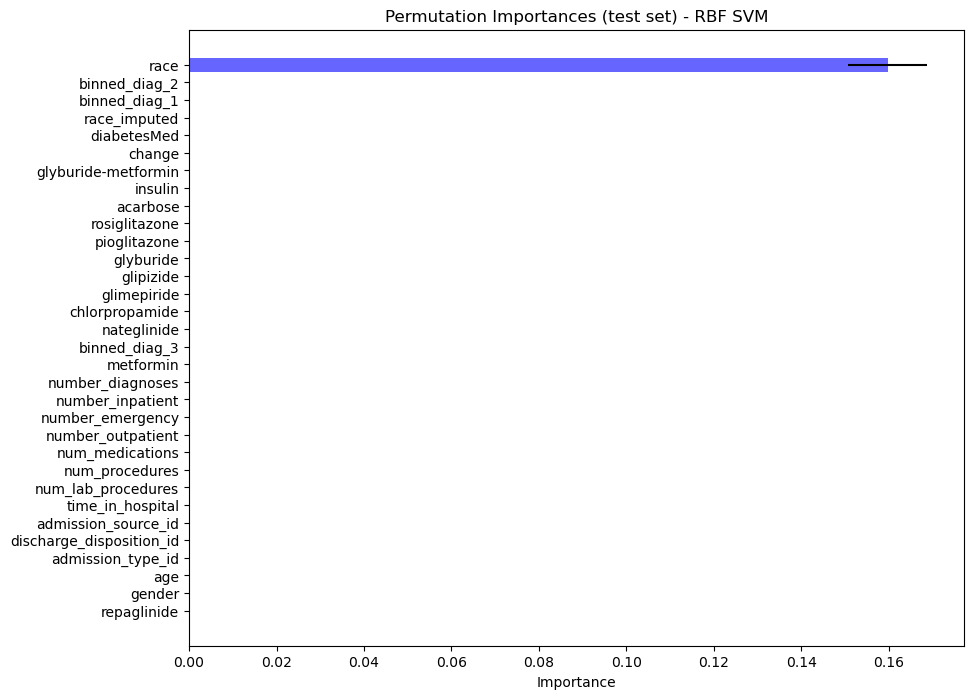

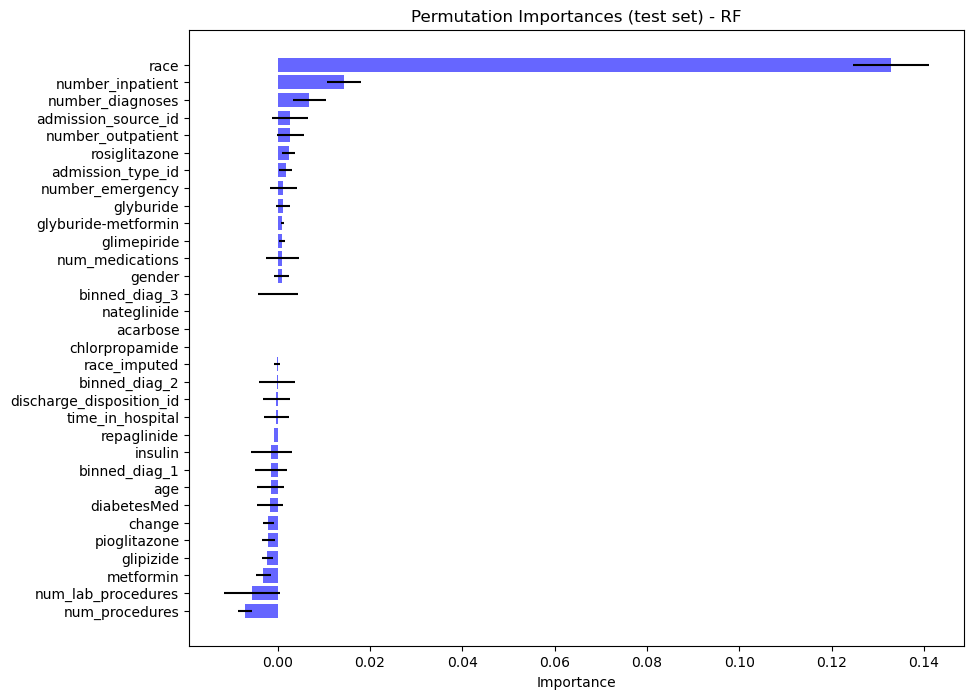

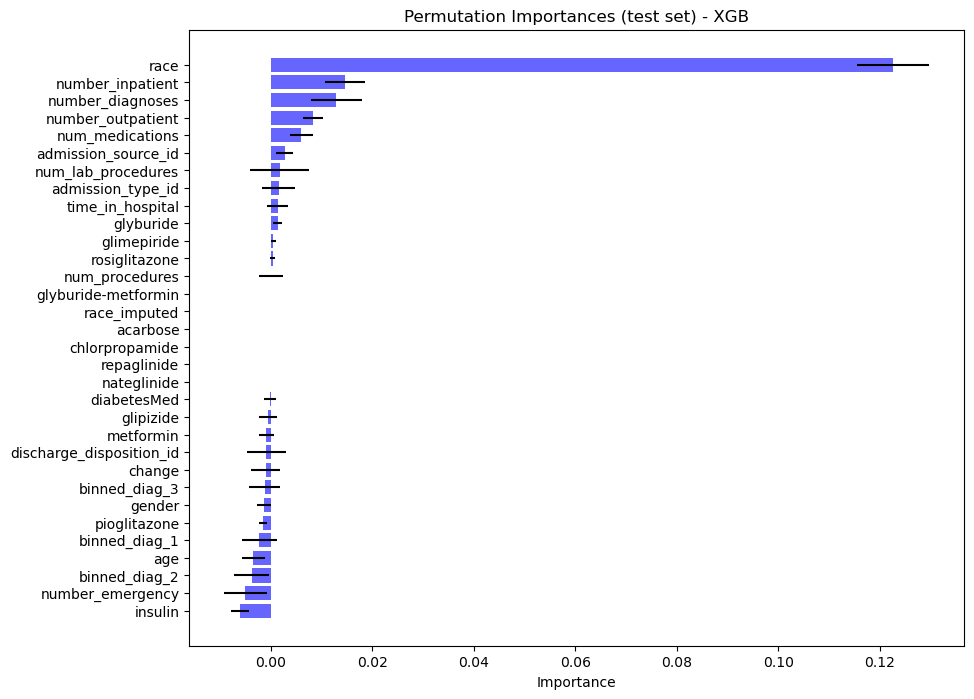

In [62]:
for model_name, df in perm_importances.items():
    # Sort the DataFrame by importance
    df = df.sort_values(by='importance', ascending=True)
    
    # Create a bar plot of the feature importances with error bars
    plt.figure(figsize=(10, 8))
    plt.barh(df['feature'], df['importance'], xerr=df['std_dev'], color='b', alpha=0.6)
    plt.xlabel('Importance')
    plt.title(f'Permutation Importances (test set) - {model_name}')
    plt.show()

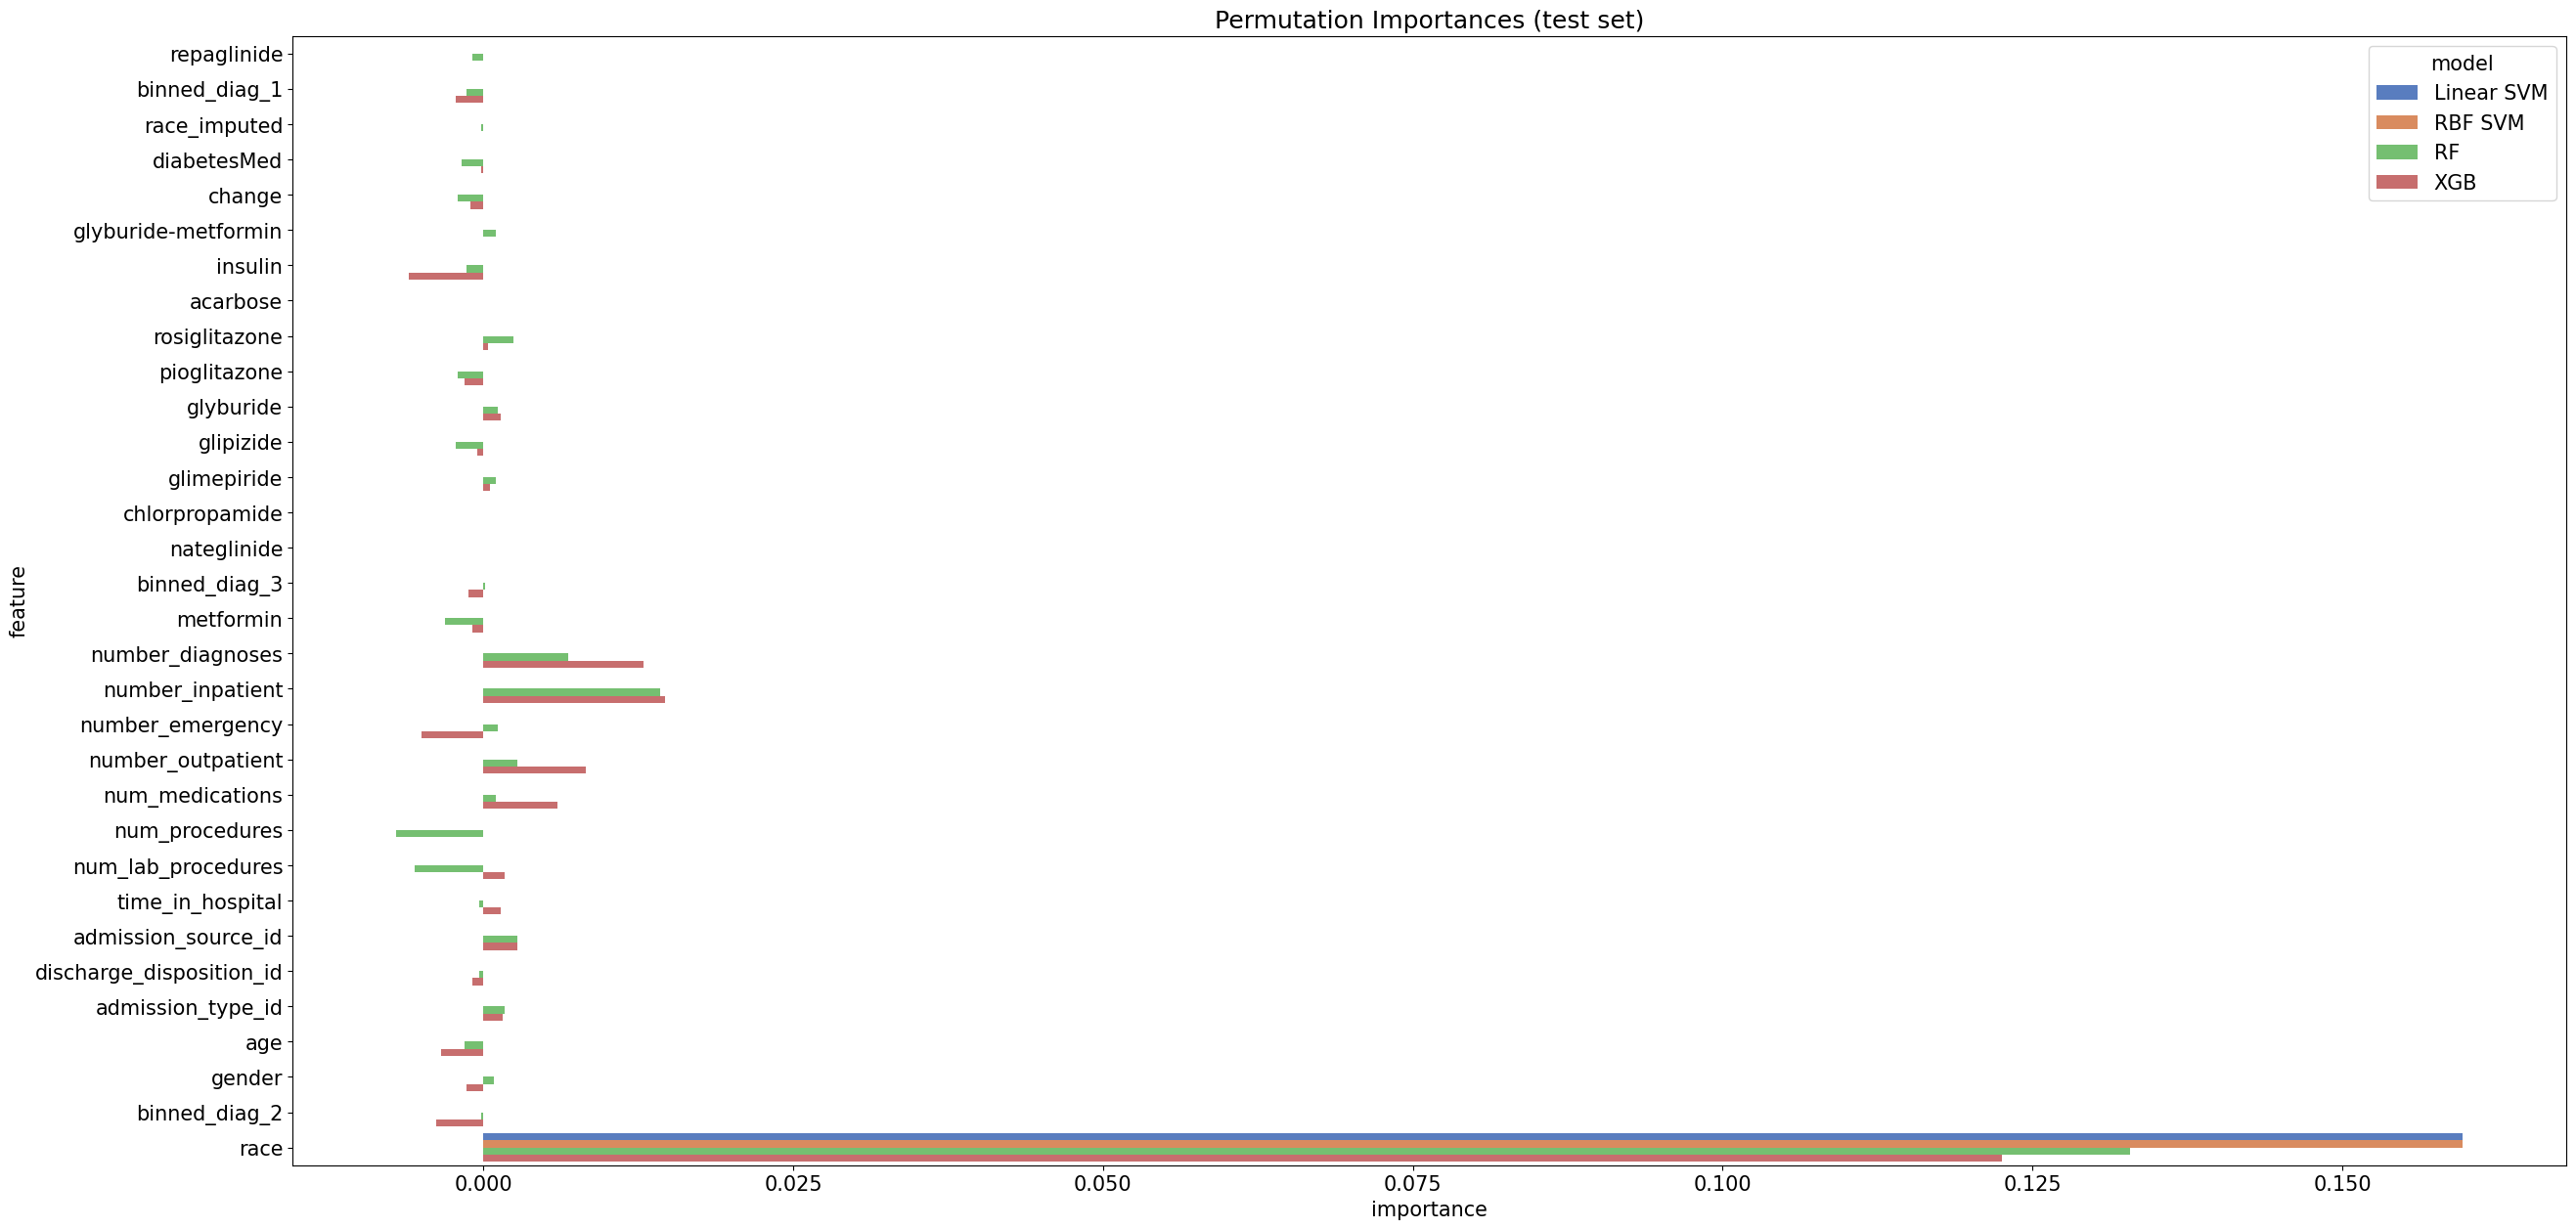

In [63]:
# Set the default font size
plt.rcParams['font.size'] = 15
# Concatenate all dataframes in perm_importances into one dataframe
all_importances = pd.concat([df.assign(model=model_name) for model_name, df in perm_importances.items()])

# Create a figure
plt.figure(figsize=(30, 15))

# Plot the importances with a color palette
sns.barplot(x='importance', y='feature', hue='model', data=all_importances, palette='muted')

# Set the title
plt.title("Permutation Importances (test set)")

plt.show()

# Task 5. Alternative machine learning pipeline

In [65]:
models = {
    'Linear SVM': (SVC(kernel="linear"), SVM_linear_params),
    'RBF SVM': (SVC(kernel="rbf"), SVM_params), 
    'RF': (RandomForestClassifier(), RF_params),
    'XGB': (XGBClassifier(), XGB_params)}

# Define the function to run nested cross-validation
def run_nested_cv(models_dict, model, scoring, cv, X, y):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', models_dict[model][0])
    ])
    
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    nested_scores = {'f2': [], 'accuracy': [], 'test_f2': [], 'test_accuracy': []}  # Add lists for best scores
    
    best_params = []
    
    for train_index, test_index in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        grid_search = GridSearchCV(estimator=pipeline, param_grid=models_dict[model][1], cv=inner_cv, scoring=scoring, refit="f2", n_jobs=6)
        grid_search.fit(X_train, y_train)
        nested_scores['f2'].append(grid_search.cv_results_['mean_test_f2'].mean())
        nested_scores['accuracy'].append(grid_search.cv_results_['mean_test_accuracy'].mean())
        best_params.append(grid_search.best_params_)
        
        # Predict the test set results
        y_pred = grid_search.predict(X_test)

        # Calculate the 'f2' and 'accuracy' scores
        f2_score = fbeta_score(y_test, y_pred, beta=2)
        acc_score = accuracy_score(y_test, y_pred)  # Rename the variable

        # Append the scores to the 'nested_scores' dictionary
        nested_scores['test_f2'].append(f2_score)
        nested_scores['test_accuracy'].append(acc_score)  # Use the renamed variable
                
    return nested_scores, best_params


X_entire = pd.concat([X_train, X_test], axis=0)
y_entire = pd.concat([y_train, y_test], axis=0)

# Run nested cross-validation for each model
nested_results = {}
best_params = {}
for model in models:
    nested_results[model], best_params[model] = run_nested_cv(models, model, scoring, cv, X_entire, y_entire)

/Users/angelinamagal/miniconda3/envs/comp0189/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/angelinamagal/miniconda3/envs/comp0189/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/angelinamagal/miniconda3/envs/comp0189/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/angelinamagal/miniconda3/envs/comp0189/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all

In [69]:
pd.set_option('display.max_colwidth', None)

# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=['Mean Test F2', 'Std Test F2', 'Mean Test Accuracy', 'Std Test Accuracy', 'Best Parameters'])

# Loop over each model
for model in models:
    # Calculate the mean and standard deviation of the test f2 and test accuracy
    mean_test_f2 = np.mean(nested_results[model]['test_f2'])
    std_test_f2 = np.std(nested_results[model]['test_f2'])
    mean_test_accuracy = np.mean(nested_results[model]['test_accuracy'])
    std_test_accuracy = np.std(nested_results[model]['test_accuracy'])
    
    # Get the best parameters
    best_parameters = best_params[model]
    
    # Append the results to the DataFrame
    results_df.loc[model] = [mean_test_f2, std_test_f2, mean_test_accuracy, std_test_accuracy, best_parameters]

# Display the DataFrame
results_df

,Mean Test F2,Std Test F2,Mean Test Accuracy,Std Test Accuracy,Best Parameters
Linear SVM,0.618013,0.011549,0.649681,0.011659,"[{'classifier__C': 0.01}, {'classifier__C': 0.01}, {'classifier__C': 100}, {'classifier__C': 0.01}, {'classifier__C': 0.01}]"
RBF SVM,0.621485,0.014764,0.652611,0.011489,"[{'classifier__C': 100, 'classifier__gamma': 0.01}, {'classifier__C': 100, 'classifier__gamma': 0.01}, {'classifier__C': 1, 'classifier__gamma': 0.1}, {'classifier__C': 100, 'classifier__gamma': 0.01}, {'classifier__C': 100, 'classifier__gamma': 0.01}]"
RF,0.635534,0.012146,0.664656,0.014123,"[{'classifier__max_depth': 20, 'classifier__n_estimators': 500}, {'classifier__max_depth': 20, 'classifier__n_estimators': 1000}, {'classifier__max_depth': 20, 'classifier__n_estimators': 100}, {'classifier__max_depth': 20, 'classifier__n_estimators': 1000}, {'classifier__max_depth': 20, 'classifier__n_estimators': 200}]"
XGB,0.633861,0.017806,0.655703,0.013559,"[{'classifier__learning_rate': 0.1, 'classifier__max_depth': None, 'classifier__n_estimators': 50}, {'classifier__learning_rate': 0.01, 'classifier__max_depth': None, 'classifier__n_estimators': 1000}, {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 50}, {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}, {'classifier__learning_rate': 0.1, 'classifier__max_depth': None, 'classifier__n_estimators': 1000}]"


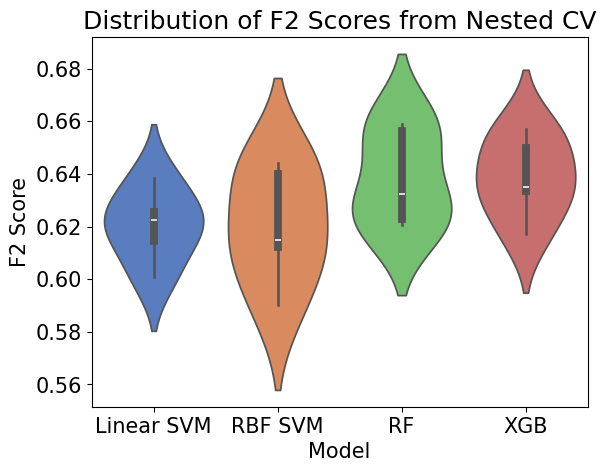

In [ ]:

nested_scores = {model: results['test_f2'] for model, results in nested_results.items()}

# Convert the nested_scores dictionary to a DataFrame
df = pd.DataFrame.from_dict(nested_scores, orient='index').transpose()

# Create a violin plot of the F2 scores
sns.violinplot(data=df, palette="muted")

# Set the title and labels
plt.title('Distribution of F2 Scores from Nested CV')
plt.xlabel('Model')
plt.ylabel('F2 Score')

# Show the plot
plt.show()

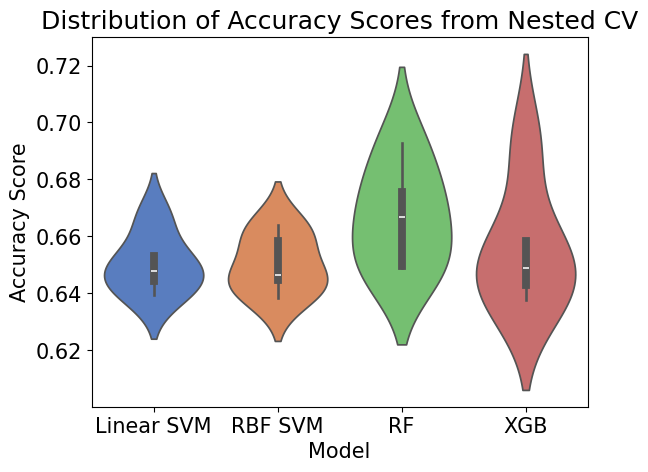

In [ ]:

nested_scores = {model: results['test_accuracy'] for model, results in nested_results.items()}

# Convert the nested_scores dictionary to a DataFrame
df = pd.DataFrame.from_dict(nested_scores, orient='index').transpose()

# Create a violin plot of the F2 scores
sns.violinplot(data=df, palette="muted")

# Set the title and labels
plt.title('Distribution of Accuracy Scores from Nested CV')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')

# Show the plot
plt.show()